In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import pandas as pd
import random
import wandb
from tqdm import tqdm
import os
import math

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.font_manager as fm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Run for kaggle only
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("WANDB_API_KEY")

wandb_api_key = secret_value_0 #os.getenv("WANDB_API_KEY")
wandb.login(key=wandb_api_key)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24m021 (da24m021-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Get Data

In [ ]:
# My PC :- Used for initial experiments
TRAIN_FilePath = 'dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv'
DEV_FilePath = 'dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv'
TEST_FilePath = 'dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv'

In [3]:
# COLAB :- Used to check if code if gpu supporting and run experiments
from google.colab import drive
drive.mount('/content/drive')
TRAIN_FilePath = '/content/drive/My Drive/hi/lexicons/hi.translit.sampled.train.tsv'
DEV_FilePath = '/content/drive/My Drive/hi/lexicons/hi.translit.sampled.dev.tsv'
TEST_FilePath = '/content/drive/My Drive/hi/lexicons/hi.translit.sampled.test.tsv'

Mounted at /content/drive


In [ ]:
# KAGGLE :- Used for hyperparameter tuning
TRAIN_FilePath = "/kaggle/input/dakshinahindi/hi/lexicons/hi.translit.sampled.train.tsv"
DEV_FilePath = "/kaggle/input/dakshinahindi/hi/lexicons/hi.translit.sampled.dev.tsv"
TEST_FilePath = "/kaggle/input/dakshinahindi/hi/lexicons/hi.translit.sampled.test.tsv"

## Data Loading and Preprocessing

In [4]:
# Load train, dev and test datasets
train_df = pd.read_csv(TRAIN_FilePath, sep='\t', header=None)
dev_df = pd.read_csv(DEV_FilePath, sep='\t', header=None)
test_df = pd.read_csv(TEST_FilePath, sep='\t', header=None)


# Renaming the columns
train_df.columns = ['devanagari', 'latin', 'frequency']
dev_df.columns = ['devanagari', 'latin', 'frequency']
test_df.columns = ['devanagari', 'latin', 'frequency']

# Dataset Sizes
print(f"Train Dataset Size : {train_df.shape[0]}\nDev Dataset Size   : {dev_df.shape[0]}\nTest Dataset Size  : {test_df.shape[0]}")

Train Dataset Size : 44204
Dev Dataset Size   : 4358
Test Dataset Size  : 4502


In [5]:
train_df.head()

,devanagari,latin,frequency
0,अं,an,3
1,अंकगणित,ankganit,3
2,अंकल,uncle,4
3,अंकुर,ankur,4
4,अंकुरण,ankuran,3


In [6]:
class Vocabulary:
    def __init__(self):
        self.pad_token = "<pad>"
        self.sos_token = "<sos>"
        self.eos_token = "<eos>"
        self.unk_token = "<unk>"

        # Initialize mappings
        self.char2idx = {self.pad_token: 0, self.sos_token: 1, self.eos_token: 2, self.unk_token: 3}
        self.idx2char = {0: self.pad_token, 1: self.sos_token, 2: self.eos_token, 3: self.unk_token}
        self.vocab_size = 4

    def build_vocabulary(self, text_data):
        for text in text_data:
            text = str(text)
            for char in text:
                if char not in self.char2idx:
                    self.char2idx[char] = self.vocab_size
                    self.idx2char[self.vocab_size] = char
                    self.vocab_size += 1

    def encode(self, text, add_special_tokens=True):
        indices = []
        text = str(text)
        for char in text:
            indices.append(self.char2idx.get(char, self.char2idx[self.unk_token]))

        if add_special_tokens:
            indices = [self.char2idx[self.sos_token]] + indices + [self.char2idx[self.eos_token]]

        return indices

    def decode(self, indices, remove_special_tokens=True):
        chars = []
        keys = list(self.idx2char.keys())
        for idx in indices:
            if isinstance(idx, torch.Tensor):
                idx = idx.item()
            if idx in keys:
                char = self.idx2char[idx]
                if remove_special_tokens and char in [self.pad_token, self.sos_token, self.eos_token, self.unk_token]:
                    continue
                chars.append(char)

        return "".join(chars)


In [7]:
class TransliterationDataset(Dataset):
    def __init__(self, data_path, src_vocab, tgt_vocab):
        df = pd.read_csv(data_path, sep='\t', header=None)

        # Create Dataset
        self.source_sequences = []
        self.target_sequences = []

        for idx, row in df.iterrows():
            x_seq = src_vocab.encode(row[1])
            y_seq = tgt_vocab.encode(row[0])
            self.source_sequences.append(x_seq)
            self.target_sequences.append(y_seq)

    def __len__(self):
        return len(self.source_sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.source_sequences[idx], dtype=torch.long), torch.tensor(self.target_sequences[idx], dtype=torch.long)


In [8]:
def collate_fn(batch):
    src_batch = [item[0] for item in batch]
    tgt_batch = [item[1] for item in batch]

    # Pad sequences
    src_batch_padded = pad_sequence(src_batch, batch_first=True, padding_value=0)
    tgt_batch_padded = pad_sequence(tgt_batch, batch_first=True, padding_value=0)

    return src_batch_padded, tgt_batch_padded

In [9]:
# Build Source and Target Vocabularies
src_vocab = Vocabulary()
tgt_vocab = Vocabulary()

train_df = pd.read_csv(TRAIN_FilePath, sep='\t', header=None)
src_text = []
tgt_text = []
for idx, row in train_df.iterrows():
    src_text.append(row[1])
    tgt_text.append(row[0])

src_vocab.build_vocabulary(src_text)
tgt_vocab.build_vocabulary(tgt_text)

In [10]:
# Train, Test and Dev (Validation) Dataset and Dataloaders
train_dataset = TransliterationDataset(TRAIN_FilePath, src_vocab, tgt_vocab)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

dev_dataset = TransliterationDataset(DEV_FilePath, src_vocab, tgt_vocab)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

test_dataset = TransliterationDataset(TEST_FilePath, src_vocab, tgt_vocab)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


In [11]:
# Inspect if dataloader is created as desired
for batch in train_loader:
    inputs, targets = batch

    print("Inputs shape:", inputs.shape)
    print("Targets shape:", targets.shape)

    # Check one sample
    print("Sample input:", inputs[0])
    print("Sample target:", targets[0])
    print(src_vocab.decode(inputs[0]))
    print(tgt_vocab.decode(targets[0]))
    break

Inputs shape: torch.Size([32, 15])
Targets shape: torch.Size([32, 14])
Sample input: tensor([ 1,  6,  8, 11, 16, 13,  5,  2,  0,  0,  0,  0,  0,  0,  0])
Sample target: tensor([ 1,  6,  9, 28, 16,  2,  0,  0,  0,  0,  0,  0,  0,  0])
kichen
किचन


## Vanilla Model

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers=1, cell_type="RNN", dropout=0.0):
        super().__init__()

        if num_layers == 1:
            dropout = 0

        self.cell_type = cell_type

        # Embedding Layer
        self.embedding = nn.Embedding(input_size, embedding_size)

        # Recurrent Layer
        if cell_type == "LSTM":
            self.recurrent_layer = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        elif cell_type == "GRU":
            self.recurrent_layer = nn.GRU(embedding_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        else: # Default (RNN)
            self.recurrent_layer = nn.RNN(embedding_size, hidden_size, num_layers, dropout=dropout, batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        # input: batch_size x seq_len

        embeddings = self.embedding(input) # (batch, seq_len, embedding_size)
        embeddings = self.dropout(embeddings)

        if self.cell_type == 'LSTM':
            outputs, (hidden, cell) = self.recurrent_layer(embeddings)
            return outputs, (hidden, cell)
        else:
            outputs, hidden = self.recurrent_layer(embeddings)
            return outputs, hidden


In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, hidden_size, num_layers=1, cell_type="RNN", dropout=0.0):
        super().__init__()

        if num_layers == 1:
            dropout = 0

        self.output_size = output_size
        self.cell_type = cell_type

        # Embedding Layer
        self.embedding = nn.Embedding(output_size, embedding_size)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Recurrent Layer
        if cell_type == "LSTM":
            self.recurrent_layer = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        elif cell_type == "GRU":
            self.recurrent_layer = nn.GRU(embedding_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        else: # Default (RNN)
            self.recurrent_layer = nn.RNN(embedding_size, hidden_size, num_layers, dropout=dropout, batch_first=True)

        # Output layer
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):

        input = input.unsqueeze(1)
        embeddings = self.embedding(input)
        embeddings = self.dropout(embeddings)

        if self.cell_type == "LSTM":
            hidden, cell = hidden
            outputs, (hidden, cell) = self.recurrent_layer(embeddings, (hidden, cell))
            hidden = (hidden, cell)
        else:
            outputs, hidden = self.recurrent_layer(embeddings, hidden)

        outputs = outputs.squeeze(1)
        prediction = self.fc_out(outputs)
        return prediction, hidden


In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):

        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.output_size

        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)

        if self.encoder.cell_type == 'LSTM':
            encoder_outputs, (hidden, cell) = self.encoder(src)
            decoder_hidden = (hidden, cell)
        else:
            encoder_outputs, hidden = self.encoder(src)
            decoder_hidden = hidden

        decoder_input = tgt[:, 0]
        for t in range(1, tgt_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            #print(decoder_output.shape)
            #break
            outputs[:, t] = decoder_output
            top = decoder_output.argmax(1)
            decoder_input = tgt[:, t] if random.random() < teacher_forcing_ratio else top
        return outputs


    def inference(self, src, max_len, sos_idx=1, eos_idx=2):

        batch_size = src.shape[0]
        tgt_len = max_len
        tgt_vocab_size = self.decoder.output_size
        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)

        if self.encoder.cell_type == 'LSTM':
            encoder_outputs, (hidden, cell) = self.encoder(src)
            decoder_hidden = (hidden, cell)
        else:
            encoder_outputs, hidden = self.encoder(src)
            decoder_hidden = hidden

        decoder_input = torch.tensor([sos_idx] * batch_size, device=self.device)
        for t in range(1, max_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[:, t] = decoder_output
            top = decoder_output.argmax(1)
            decoder_input = top

            # Check if all sequences have reached <eos>
            if (outputs == eos_idx).any(dim=1).all():
                break
        return outputs

## Training and Evaluation of Vanilla Model

In [ ]:
def train(model, train_loader, optimizer, criterion, clip=1.0, teacher_forcing_ratio=0.5):
    model.train()
    epoch_loss = 0

    for i, (src, tgt) in enumerate(train_loader):
        src = src.to(device)
        tgt = tgt.to(device)
        #print("tgt", tgt)
        optimizer.zero_grad()

        output = model(src, tgt, teacher_forcing_ratio)
        #print("output", output)
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        tgt = tgt[:, 1:].reshape(-1)
        #print("tgt2", tgt)
        #print("output2", output)
        #break

        # Calculate loss
        loss = criterion(output, tgt)

        # Backpropagation
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # Update parameters
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(train_loader)

In [ ]:
def evaluate(model, val_loader, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, (src, tgt) in enumerate(val_loader):
            src = src.to(device)
            tgt = tgt.to(device)

            output = model.inference(src, tgt.shape[1])

            # Reshape output and target for loss calculation
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            tgt = tgt[:, 1:].reshape(-1)

            # Calculate loss
            loss = criterion(output, tgt)
            epoch_loss += loss.item()

    return epoch_loss / len(val_loader)

In [ ]:
def transliterate(model, src_text, src_vocab, tgt_vocab, device, max_length=100):
    model.eval()

    # Convert source text to tensor
    src_indices = src_vocab.encode(src_text)
    src_tensor = torch.tensor(src_indices, dtype=torch.long).unsqueeze(0).to(device)

    # Get encoder outputs
    with torch.no_grad():
        if model.encoder.cell_type == 'LSTM':
            encoder_outputs, (hidden, cell) = model.encoder(src_tensor)
            decoder_hidden = (hidden, cell)
        else:
            encoder_outputs, hidden = model.encoder(src_tensor)
            decoder_hidden = hidden

    # Start with SOS token
    decoder_input = torch.tensor([tgt_vocab.char2idx[tgt_vocab.sos_token]], device=device)

    result_indices = [tgt_vocab.char2idx[tgt_vocab.sos_token]]

    for _ in range(max_length):
        with torch.no_grad():
            decoder_output, decoder_hidden = model.decoder(decoder_input, decoder_hidden)

        # Get the most likely next character
        top_token = decoder_output.argmax(1).item()
        result_indices.append(top_token)

        # Stop if EOS token
        if top_token == tgt_vocab.char2idx[tgt_vocab.eos_token]:
            break

        # Use predicted token as next input
        decoder_input = torch.tensor([top_token], device=device)

    # Convert indices to text
    result_text = tgt_vocab.decode(result_indices, remove_special_tokens=True)

    return result_text

In [ ]:
# Accuracy calculation function
def calculate_accuracy(model, data_loader, src_vocab, tgt_vocab, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for src, tgt in data_loader:
            src = src.to(device)
            tgt = tgt.to(device)

            batch_size = src.shape[0]

            for i in range(batch_size):
                # Get source text and actual target text
                src_indices = src[i].tolist()
                src_text = src_vocab.decode(src_indices)
                actual_tgt_text = tgt_vocab.decode(tgt[i].tolist())

                # Get predicted transliteration
                predicted_tgt_text = transliterate(model, src_text, src_vocab, tgt_vocab, device)

                # Check if prediction matches
                if predicted_tgt_text == actual_tgt_text:
                    correct += 1
                total += 1

    return correct / total

## Sample Run of Vanilla Model

In [ ]:
INPUT_SIZE = src_vocab.vocab_size
OUTPUT_SIZE = tgt_vocab.vocab_size
EMBEDDING_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 2
CELL_TYPE = "LSTM"
DROPOUT = 0.2
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

# Initialize encoder, decoder, and seq2seq model
encoder = Encoder(
    input_size=INPUT_SIZE,
    embedding_size=EMBEDDING_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    cell_type=CELL_TYPE,
    dropout=DROPOUT
)

decoder = Decoder(
    output_size=OUTPUT_SIZE,
    embedding_size=EMBEDDING_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    cell_type=CELL_TYPE,
    dropout=DROPOUT
)

model = Seq2Seq(encoder, decoder, device).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Training loop
print(f"Starting training for {NUM_EPOCHS} epochs...")

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")

    # Train model
    train_loss = train(model, train_loader, optimizer, criterion)

    # Evaluate model
    valid_loss = evaluate(model, dev_loader, criterion)

    print(f"Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")
    print("="*20)

Starting training for 10 epochs...
Epoch 1/10
Train Loss: 1.6911 | Valid Loss: 1.2774
Epoch 2/10
Train Loss: 0.7447 | Valid Loss: 1.0841
Epoch 3/10
Train Loss: 0.5753 | Valid Loss: 1.0521
Epoch 4/10
Train Loss: 0.4678 | Valid Loss: 1.0716
Epoch 5/10
Train Loss: 0.3957 | Valid Loss: 1.0537
Epoch 6/10
Train Loss: 0.3445 | Valid Loss: 1.0727
Epoch 7/10
Train Loss: 0.3004 | Valid Loss: 1.1386
Epoch 8/10
Train Loss: 0.2758 | Valid Loss: 1.1567
Epoch 9/10
Train Loss: 0.2444 | Valid Loss: 1.2164
Epoch 10/10
Train Loss: 0.2251 | Valid Loss: 1.2348


In [ ]:
val_accuracy = calculate_accuracy(model, dev_loader, src_vocab, tgt_vocab, device)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")


Validation Accuracy: 0.3502


## Hyperparameter Tuning of Vanilla Model

In [ ]:
def sweep_hyperparameters(config=None):
    with wandb.init(config=config):
        config = wandb.config
        wandb.run.name = f"embedding_size_{str(config.embedding_size)}_num_layers_{str(config.num_layers)}_hidden_size_{config.hidden_size} \
                          _cell_type_{config.cell_type}_dp_{config.dropout}_lr_{config.learning_rate}_batch_{config.batch_size}"

        # Log in my details
        wandb.config.update({"NAME": "SIDDHANT BARANWAL", "ROLL NO.": "DA24M021"})

        train_dataset = TransliterationDataset(TRAIN_FilePath, src_vocab, tgt_vocab)
        train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, collate_fn=collate_fn)

        dev_dataset = TransliterationDataset(DEV_FilePath, src_vocab, tgt_vocab)
        dev_loader = DataLoader(dev_dataset, batch_size=config.batch_size, shuffle=False, collate_fn=collate_fn)

        INPUT_SIZE = src_vocab.vocab_size
        OUTPUT_SIZE = tgt_vocab.vocab_size

        EMBEDDING_SIZE = config.embedding_size
        HIDDEN_SIZE = config.hidden_size
        NUM_LAYERS = config.num_layers
        CELL_TYPE = config.cell_type
        DROPOUT = config.dropout
        LEARNING_RATE = config.learning_rate
        NUM_EPOCHS = 10

        # Initialize encoder, decoder, and seq2seq model
        encoder = Encoder(
            input_size=INPUT_SIZE,
            embedding_size=EMBEDDING_SIZE,
            hidden_size=HIDDEN_SIZE,
            num_layers=NUM_LAYERS,
            cell_type=CELL_TYPE,
            dropout=DROPOUT
        )

        decoder = Decoder(
            output_size=OUTPUT_SIZE,
            embedding_size=EMBEDDING_SIZE,
            hidden_size=HIDDEN_SIZE,
            num_layers=NUM_LAYERS,
            cell_type=CELL_TYPE,
            dropout=DROPOUT
        )

        model = Seq2Seq(encoder, decoder, device).to(device)
        criterion = nn.CrossEntropyLoss(ignore_index=0)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

        for epoch in tqdm(range(NUM_EPOCHS)):
            # Train model
            train_loss = train(model, train_loader, optimizer, criterion)
            # Evaluate model
            valid_loss = evaluate(model, dev_loader, criterion)

            print(f"Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")
            # Log the evaluation metrics
            wandb.log({
                "epoch": epoch,
                "train_loss": train_loss,
                "validation_loss": valid_loss,
                })

        # Calculate accuracy on validation set
        val_accuracy = calculate_accuracy(model, dev_loader, src_vocab, tgt_vocab, device)
        print(f"\nValidation Accuracy: {val_accuracy:.4f}")
        wandb.log({
            "val_accuracy": val_accuracy
        })

In [ ]:
sweep_config = {
    "method" : "bayes",
    "metric" : {"name": "val_accuracy", "goal": "maximize"},
    "parameters" : {
        "embedding_size" : {"values" : [16, 32, 64, 256, 512, 1024]},
        "num_layers" : {"values" : [1, 2, 3, 4]},
        "hidden_size" : {"values" : [16, 32, 64, 128, 256, 512, 1024, 2048]},
        "cell_type" : {"values" : ["RNN", "LSTM", "GRU"]},
        "dropout" : {"values" : [0.0, 0.2, 0.3, 0.4]},
        "learning_rate" : {"values" : [0.01, 0.001, 0.0005]},
        "batch_size": {"values": [16, 32]}
    }
}

sweep_id = wandb.sweep(sweep_config, project = "da24m021_da6401_assignment3")
wandb.agent(sweep_id, function = sweep_hyperparameters, count = 30)

Create sweep with ID: 6g2ha9nv
Sweep URL: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/sweeps/6g2ha9nv


wandb: Agent Starting Run: x760x6ri with config:
wandb: 	batch_size: 32
wandb: 	cell_type: GRU
wandb: 	dropout: 0.4
wandb: 	embedding_size: 16
wandb: 	hidden_size: 2048
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250514_062949-x760x6ri
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run sandy-sweep-1
wandb: ⭐️ View project at https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: 🧹 View sweep at https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/sweeps/6g2ha9nv
wandb: 🚀 View run at https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/x760x6ri
 10%|█         | 1/10 [00:42<06:23, 42.56s/it]

Train Loss: 1.0674 | Valid Loss: 0.9679


 20%|██        | 2/10 [01:24<05:39, 42.44s/it]

Train Loss: 0.3931 | Valid Loss: 0.8412


 30%|███       | 3/10 [02:07<04:57, 42.44s/it]

Train Loss: 0.2653 | Valid Loss: 0.9011


 40%|████      | 4/10 [02:50<04:15, 42.55s/it]

Train Loss: 0.1995 | Valid Loss: 0.9560


 50%|█████     | 5/10 [03:32<03:33, 42.65s/it]

Train Loss: 0.1608 | Valid Loss: 1.0607


 60%|██████    | 6/10 [04:15<02:50, 42.67s/it]

Train Loss: 0.1403 | Valid Loss: 1.0887


 70%|███████   | 7/10 [04:58<02:07, 42.66s/it]

Train Loss: 0.1326 | Valid Loss: 1.0682


 80%|████████  | 8/10 [05:40<01:25, 42.69s/it]

Train Loss: 0.1211 | Valid Loss: 1.1039


 90%|█████████ | 9/10 [06:23<00:42, 42.68s/it]

Train Loss: 0.1148 | Valid Loss: 1.1140


100%|██████████| 10/10 [07:06<00:00, 42.64s/it]

Train Loss: 0.1148 | Valid Loss: 1.2005



Validation Accuracy: 0.3022


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss █▃▂▂▁▁▁▁▁▁
wandb:    val_accuracy ▁
wandb: validation_loss ▃▁▂▃▅▆▅▆▆█
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 0.1148
wandb:    val_accuracy 0.3022
wandb: validation_loss 1.20051
wandb: 
wandb: 🚀 View run embedding_size_16_num_layers_1_hidden_size_2048                           _cell_type_GRU_dp_0.4_lr_0.001_batch_32 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/x760x6ri
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_062949-x760x6ri/logs
wandb: Agent Starting Run: fscbzjin with config:
wandb: 	batch_size: 32
wandb: 	cell_type: LSTM
w

Train Loss: 1.6832 | Valid Loss: 1.7699


 20%|██        | 2/10 [02:23<09:33, 71.63s/it]

Train Loss: 0.9383 | Valid Loss: 1.0246


 30%|███       | 3/10 [03:34<08:21, 71.59s/it]

Train Loss: 0.4509 | Valid Loss: 0.8852


 40%|████      | 4/10 [04:46<07:09, 71.55s/it]

Train Loss: 0.3276 | Valid Loss: 0.8264


 50%|█████     | 5/10 [05:58<05:58, 71.62s/it]

Train Loss: 0.2519 | Valid Loss: 0.9242


 60%|██████    | 6/10 [07:09<04:46, 71.64s/it]

Train Loss: 0.2019 | Valid Loss: 0.9092


 70%|███████   | 7/10 [08:21<03:34, 71.62s/it]

Train Loss: 0.1653 | Valid Loss: 0.9440


 80%|████████  | 8/10 [09:33<02:23, 71.80s/it]

Train Loss: 0.1406 | Valid Loss: 0.9886


 90%|█████████ | 9/10 [10:45<01:11, 71.84s/it]

Train Loss: 0.1236 | Valid Loss: 0.9803


100%|██████████| 10/10 [11:57<00:00, 71.70s/it]

Train Loss: 0.1086 | Valid Loss: 1.0134



Validation Accuracy: 0.3410


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss █▅▃▂▂▁▁▁▁▁
wandb:    val_accuracy ▁
wandb: validation_loss █▂▁▁▂▂▂▂▂▂
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 0.10863
wandb:    val_accuracy 0.34098
wandb: validation_loss 1.01338
wandb: 
wandb: 🚀 View run embedding_size_64_num_layers_3_hidden_size_1024                           _cell_type_LSTM_dp_0_lr_0.001_batch_32 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/fscbzjin
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_063726-fscbzjin/logs
wandb: Agent Starting Run: fe13dpon with config:
wandb: 	batch_size: 32
wandb: 	cell_type: RNN
w

Train Loss: 1.8696 | Valid Loss: 2.5516


 20%|██        | 2/10 [01:04<04:18, 32.31s/it]

Train Loss: 1.7705 | Valid Loss: 2.3840


 30%|███       | 3/10 [01:37<03:47, 32.46s/it]

Train Loss: 1.7303 | Valid Loss: 2.3232


 40%|████      | 4/10 [02:10<03:15, 32.64s/it]

Train Loss: 1.7143 | Valid Loss: 2.3936


 50%|█████     | 5/10 [02:42<02:43, 32.63s/it]

Train Loss: 1.7004 | Valid Loss: 2.2954


 60%|██████    | 6/10 [03:15<02:10, 32.50s/it]

Train Loss: 1.6785 | Valid Loss: 2.3325


 70%|███████   | 7/10 [03:49<01:39, 33.28s/it]

Train Loss: 1.6686 | Valid Loss: 2.3103


 80%|████████  | 8/10 [04:25<01:07, 33.92s/it]

Train Loss: 1.6666 | Valid Loss: 2.2729


 90%|█████████ | 9/10 [05:00<00:34, 34.42s/it]

Train Loss: 1.6592 | Valid Loss: 2.3277


100%|██████████| 10/10 [05:35<00:00, 33.56s/it]

Train Loss: 1.6412 | Valid Loss: 2.2606



Validation Accuracy: 0.0000


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss █▅▄▃▃▂▂▂▂▁
wandb:    val_accuracy ▁
wandb: validation_loss █▄▃▄▂▃▂▁▃▁
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 1.6412
wandb:    val_accuracy 0
wandb: validation_loss 2.26062
wandb: 
wandb: 🚀 View run embedding_size_512_num_layers_2_hidden_size_1024                           _cell_type_RNN_dp_0_lr_0.0005_batch_32 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/fe13dpon
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_064955-fe13dpon/logs
wandb: Agent Starting Run: rvznk0l1 with config:
wandb: 	batch_size: 16
wandb: 	cell_type: RNN
wandb: 

Train Loss: 1.9448 | Valid Loss: 2.3918


 20%|██        | 2/10 [02:11<08:44, 65.61s/it]

Train Loss: 1.8357 | Valid Loss: 2.3451


 30%|███       | 3/10 [03:17<07:39, 65.70s/it]

Train Loss: 1.8036 | Valid Loss: 2.3517


 40%|████      | 4/10 [04:21<06:32, 65.37s/it]

Train Loss: 1.7868 | Valid Loss: 2.3432


 50%|█████     | 5/10 [05:25<05:23, 64.61s/it]

Train Loss: 1.7846 | Valid Loss: 2.3967


 60%|██████    | 6/10 [06:29<04:17, 64.50s/it]

Train Loss: 1.7745 | Valid Loss: 2.3501


 70%|███████   | 7/10 [07:34<03:13, 64.56s/it]

Train Loss: 1.7648 | Valid Loss: 2.3447


 80%|████████  | 8/10 [08:39<02:09, 64.73s/it]

Train Loss: 1.7621 | Valid Loss: 2.3468


 90%|█████████ | 9/10 [09:43<01:04, 64.51s/it]

Train Loss: 1.7565 | Valid Loss: 2.3290


100%|██████████| 10/10 [10:47<00:00, 64.77s/it]

Train Loss: 1.7464 | Valid Loss: 2.3633



Validation Accuracy: 0.0000


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss █▄▃▂▂▂▂▂▁▁
wandb:    val_accuracy ▁
wandb: validation_loss ▇▃▃▂█▃▃▃▁▅
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 1.74641
wandb:    val_accuracy 0
wandb: validation_loss 2.36334
wandb: 
wandb: 🚀 View run embedding_size_256_num_layers_3_hidden_size_256                           _cell_type_RNN_dp_0.4_lr_0.0005_batch_16 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/rvznk0l1
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_065605-rvznk0l1/logs
wandb: Agent Starting Run: 30pv1rr6 with config:
wandb: 	batch_size: 32
wandb: 	cell_type: LSTM
wand

Train Loss: 1.5870 | Valid Loss: 1.3883


 20%|██        | 2/10 [07:21<29:27, 220.95s/it]

Train Loss: 0.6349 | Valid Loss: 0.8958


 30%|███       | 3/10 [11:02<25:47, 221.02s/it]

Train Loss: 0.3742 | Valid Loss: 0.8377


 40%|████      | 4/10 [14:43<22:06, 221.02s/it]

Train Loss: 0.2659 | Valid Loss: 0.8882


 50%|█████     | 5/10 [18:25<18:25, 221.07s/it]

Train Loss: 0.1992 | Valid Loss: 0.8943


 60%|██████    | 6/10 [22:06<14:44, 221.13s/it]

Train Loss: 0.1559 | Valid Loss: 0.8746


 70%|███████   | 7/10 [25:47<11:03, 221.24s/it]

Train Loss: 0.1269 | Valid Loss: 0.9596


 80%|████████  | 8/10 [29:28<07:22, 221.18s/it]

Train Loss: 0.1046 | Valid Loss: 1.0074


 90%|█████████ | 9/10 [33:09<03:41, 221.15s/it]

Train Loss: 0.0944 | Valid Loss: 1.0543


100%|██████████| 10/10 [36:51<00:00, 221.12s/it]

Train Loss: 0.0858 | Valid Loss: 1.0961



Validation Accuracy: 0.3212


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss █▄▂▂▂▁▁▁▁▁
wandb:    val_accuracy ▁
wandb: validation_loss █▂▁▂▂▁▃▃▄▄
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 0.0858
wandb:    val_accuracy 0.32125
wandb: validation_loss 1.09606
wandb: 
wandb: 🚀 View run embedding_size_64_num_layers_3_hidden_size_2048                           _cell_type_LSTM_dp_0_lr_0.001_batch_32 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/30pv1rr6
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_070720-30pv1rr6/logs
wandb: Agent Starting Run: 7uohk3os with config:
wandb: 	batch_size: 32
wandb: 	cell_type: GRU
wa

Train Loss: 0.8256 | Valid Loss: 0.9673


 20%|██        | 2/10 [07:52<31:28, 236.02s/it]

Train Loss: 0.3991 | Valid Loss: 0.9331


 30%|███       | 3/10 [11:48<27:31, 236.00s/it]

Train Loss: 0.3110 | Valid Loss: 0.9416


 40%|████      | 4/10 [15:44<23:35, 236.00s/it]

Train Loss: 0.2630 | Valid Loss: 1.0093


 50%|█████     | 5/10 [19:40<19:40, 236.03s/it]

Train Loss: 0.2313 | Valid Loss: 0.9361


 60%|██████    | 6/10 [23:36<15:44, 236.03s/it]

Train Loss: 0.2128 | Valid Loss: 0.9970


 70%|███████   | 7/10 [27:31<11:47, 235.93s/it]

Train Loss: 0.2070 | Valid Loss: 1.0169


 80%|████████  | 8/10 [31:27<07:51, 235.93s/it]

Train Loss: 0.2021 | Valid Loss: 0.9949


 90%|█████████ | 9/10 [35:23<03:55, 235.95s/it]

Train Loss: 0.1891 | Valid Loss: 1.0453


100%|██████████| 10/10 [39:19<00:00, 235.97s/it]

Train Loss: 0.1850 | Valid Loss: 1.0523



Validation Accuracy: 0.3426


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss █▃▂▂▂▁▁▁▁▁
wandb:    val_accuracy ▁
wandb: validation_loss ▃▁▂▅▁▅▆▅██
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 0.18497
wandb:    val_accuracy 0.34259
wandb: validation_loss 1.05226
wandb: 
wandb: 🚀 View run embedding_size_64_num_layers_4_hidden_size_2048                           _cell_type_GRU_dp_0_lr_0.0005_batch_32 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/7uohk3os
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_074517-7uohk3os/logs
wandb: Agent Starting Run: vpscd3wq with config:
wandb: 	batch_size: 32
wandb: 	cell_type: GRU
w

Train Loss: 3.1389 | Valid Loss: 3.5658


 20%|██        | 2/10 [02:43<10:54, 81.81s/it]

Train Loss: 3.1354 | Valid Loss: 3.4678


 30%|███       | 3/10 [04:05<09:32, 81.85s/it]

Train Loss: 3.1062 | Valid Loss: 3.4313


 40%|████      | 4/10 [05:27<08:10, 81.82s/it]

Train Loss: 3.1680 | Valid Loss: 3.4684


 50%|█████     | 5/10 [06:49<06:49, 81.82s/it]

Train Loss: 3.0956 | Valid Loss: 3.3346


 60%|██████    | 6/10 [08:10<05:26, 81.75s/it]

Train Loss: 3.0662 | Valid Loss: 3.3870


 70%|███████   | 7/10 [09:32<04:05, 81.74s/it]

Train Loss: 3.1156 | Valid Loss: 3.5872


 80%|████████  | 8/10 [10:54<02:43, 81.73s/it]

Train Loss: 3.1406 | Valid Loss: 3.3921


 90%|█████████ | 9/10 [12:15<01:21, 81.72s/it]

Train Loss: 3.0923 | Valid Loss: 3.3760


100%|██████████| 10/10 [13:37<00:00, 81.76s/it]

Train Loss: 3.0553 | Valid Loss: 3.4310



Validation Accuracy: 0.0000


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss ▆▆▄█▄▂▅▆▃▁
wandb:    val_accuracy ▁
wandb: validation_loss ▇▅▄▅▁▂█▃▂▄
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 3.05528
wandb:    val_accuracy 0
wandb: validation_loss 3.43104
wandb: 
wandb: 🚀 View run embedding_size_256_num_layers_4_hidden_size_1024                           _cell_type_GRU_dp_0_lr_0.01_batch_32 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/vpscd3wq
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_082547-vpscd3wq/logs
wandb: Agent Starting Run: 33pi1wse with config:
wandb: 	batch_size: 32
wandb: 	cell_type: GRU
wandb: 	

Train Loss: 0.8683 | Valid Loss: 0.9529


 20%|██        | 2/10 [07:51<31:24, 235.62s/it]

Train Loss: 0.4093 | Valid Loss: 0.9091


 30%|███       | 3/10 [11:46<27:29, 235.65s/it]

Train Loss: 0.3162 | Valid Loss: 0.9200


 40%|████      | 4/10 [15:42<23:33, 235.55s/it]

Train Loss: 0.2670 | Valid Loss: 0.9463


 50%|█████     | 5/10 [19:37<19:37, 235.58s/it]

Train Loss: 0.2366 | Valid Loss: 1.0170


 60%|██████    | 6/10 [23:33<15:41, 235.49s/it]

Train Loss: 0.2207 | Valid Loss: 0.9745


 70%|███████   | 7/10 [27:28<11:46, 235.49s/it]

Train Loss: 0.2028 | Valid Loss: 0.9855


 80%|████████  | 8/10 [31:24<07:51, 235.58s/it]

Train Loss: 0.1964 | Valid Loss: 1.0618


 90%|█████████ | 9/10 [35:19<03:55, 235.48s/it]

Train Loss: 0.1896 | Valid Loss: 1.0550


100%|██████████| 10/10 [39:15<00:00, 235.54s/it]

Train Loss: 0.1900 | Valid Loss: 1.1004



Validation Accuracy: 0.3307


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss █▃▂▂▁▁▁▁▁▁
wandb:    val_accuracy ▁
wandb: validation_loss ▃▁▁▂▅▃▄▇▆█
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 0.19005
wandb:    val_accuracy 0.33066
wandb: validation_loss 1.10037
wandb: 
wandb: 🚀 View run embedding_size_32_num_layers_4_hidden_size_2048                           _cell_type_GRU_dp_0_lr_0.0005_batch_32 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/33pi1wse
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_084348-33pi1wse/logs
wandb: Agent Starting Run: 8o7u3hc0 with config:
wandb: 	batch_size: 32
wandb: 	cell_type: GRU
w

Train Loss: 0.8550 | Valid Loss: 0.9038


 20%|██        | 2/10 [05:49<23:19, 174.89s/it]

Train Loss: 0.3780 | Valid Loss: 0.8949


 30%|███       | 3/10 [08:45<20:25, 175.11s/it]

Train Loss: 0.2758 | Valid Loss: 0.8904


 40%|████      | 4/10 [11:40<17:30, 175.06s/it]

Train Loss: 0.2226 | Valid Loss: 0.9745


 50%|█████     | 5/10 [14:34<14:34, 174.98s/it]

Train Loss: 0.1856 | Valid Loss: 1.0371


 60%|██████    | 6/10 [17:29<11:39, 174.98s/it]

Train Loss: 0.1629 | Valid Loss: 1.0135


 70%|███████   | 7/10 [20:24<08:44, 174.98s/it]

Train Loss: 0.1488 | Valid Loss: 1.0710


 80%|████████  | 8/10 [23:19<05:50, 175.00s/it]

Train Loss: 0.1426 | Valid Loss: 1.0894


 90%|█████████ | 9/10 [26:15<02:55, 175.03s/it]

Train Loss: 0.1388 | Valid Loss: 1.1143


100%|██████████| 10/10 [29:10<00:00, 175.01s/it]

Train Loss: 0.1288 | Valid Loss: 1.2102



Validation Accuracy: 0.3440


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss █▃▂▂▂▁▁▁▁▁
wandb:    val_accuracy ▁
wandb: validation_loss ▁▁▁▃▄▄▅▅▆█
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 0.12878
wandb:    val_accuracy 0.34397
wandb: validation_loss 1.21016
wandb: 
wandb: 🚀 View run embedding_size_16_num_layers_3_hidden_size_2048                           _cell_type_GRU_dp_0_lr_0.0005_batch_32 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/8o7u3hc0
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_092414-8o7u3hc0/logs
wandb: Agent Starting Run: udnvb79f with config:
wandb: 	batch_size: 32
wandb: 	cell_type: GRU
w

Train Loss: 1.2562 | Valid Loss: 0.9741


 20%|██        | 2/10 [01:34<06:19, 47.46s/it]

Train Loss: 0.5921 | Valid Loss: 0.8597


 30%|███       | 3/10 [02:22<05:31, 47.34s/it]

Train Loss: 0.4442 | Valid Loss: 0.8529


 40%|████      | 4/10 [03:10<04:45, 47.58s/it]

Train Loss: 0.3662 | Valid Loss: 0.8364


 50%|█████     | 5/10 [03:58<03:59, 47.85s/it]

Train Loss: 0.3103 | Valid Loss: 0.8898


 60%|██████    | 6/10 [04:47<03:13, 48.36s/it]

Train Loss: 0.2705 | Valid Loss: 0.8659


 70%|███████   | 7/10 [05:36<02:25, 48.47s/it]

Train Loss: 0.2396 | Valid Loss: 0.8414


 80%|████████  | 8/10 [06:25<01:37, 48.59s/it]

Train Loss: 0.2155 | Valid Loss: 0.8970


 90%|█████████ | 9/10 [07:14<00:48, 48.70s/it]

Train Loss: 0.1942 | Valid Loss: 0.9335


100%|██████████| 10/10 [08:02<00:00, 48.23s/it]

Train Loss: 0.1775 | Valid Loss: 0.9492



Validation Accuracy: 0.3635


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss █▄▃▂▂▂▁▁▁▁
wandb:    val_accuracy ▁
wandb: validation_loss █▂▂▁▄▂▁▄▆▇
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 0.17749
wandb:    val_accuracy 0.36347
wandb: validation_loss 0.94915
wandb: 
wandb: 🚀 View run embedding_size_16_num_layers_3_hidden_size_512                           _cell_type_GRU_dp_0.2_lr_0.0005_batch_32 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/udnvb79f
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_095421-udnvb79f/logs
wandb: Agent Starting Run: 6udggq7e with config:
wandb: 	batch_size: 32
wandb: 	cell_type: GRU


Train Loss: 0.9544 | Valid Loss: 0.9038


 20%|██        | 2/10 [01:31<06:06, 45.84s/it]

Train Loss: 0.4494 | Valid Loss: 0.8506


 30%|███       | 3/10 [02:18<05:22, 46.13s/it]

Train Loss: 0.3314 | Valid Loss: 0.8320


 40%|████      | 4/10 [03:04<04:37, 46.27s/it]

Train Loss: 0.2637 | Valid Loss: 0.8518


 50%|█████     | 5/10 [03:51<03:51, 46.31s/it]

Train Loss: 0.2156 | Valid Loss: 0.8918


 60%|██████    | 6/10 [04:37<03:05, 46.25s/it]

Train Loss: 0.1786 | Valid Loss: 0.9679


 70%|███████   | 7/10 [05:23<02:18, 46.25s/it]

Train Loss: 0.1578 | Valid Loss: 0.9622


 80%|████████  | 8/10 [06:09<01:32, 46.27s/it]

Train Loss: 0.1372 | Valid Loss: 1.0371


 90%|█████████ | 9/10 [06:56<00:46, 46.33s/it]

Train Loss: 0.1274 | Valid Loss: 1.0526


100%|██████████| 10/10 [07:42<00:00, 46.27s/it]

Train Loss: 0.1213 | Valid Loss: 1.0846



Validation Accuracy: 0.3371


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss █▄▃▂▂▁▁▁▁▁
wandb:    val_accuracy ▁
wandb: validation_loss ▃▂▁▂▃▅▅▇▇█
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 0.12132
wandb:    val_accuracy 0.33708
wandb: validation_loss 1.08464
wandb: 
wandb: 🚀 View run embedding_size_32_num_layers_2_hidden_size_1024                           _cell_type_GRU_dp_0.2_lr_0.0005_batch_32 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/6udggq7e
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_100253-6udggq7e/logs
wandb: Agent Starting Run: dedwmc0b with config:
wandb: 	batch_size: 32
wandb: 	cell_type: LST

Train Loss: 1.6891 | Valid Loss: 1.6716


 20%|██        | 2/10 [02:00<08:02, 60.30s/it]

Train Loss: 0.9380 | Valid Loss: 1.0502


 30%|███       | 3/10 [03:00<07:01, 60.17s/it]

Train Loss: 0.5312 | Valid Loss: 0.9262


 40%|████      | 4/10 [04:01<06:03, 60.51s/it]

Train Loss: 0.3796 | Valid Loss: 0.8763


 50%|█████     | 5/10 [05:01<05:01, 60.30s/it]

Train Loss: 0.2976 | Valid Loss: 0.8615


 60%|██████    | 6/10 [06:01<04:00, 60.15s/it]

Train Loss: 0.2411 | Valid Loss: 0.8712


 70%|███████   | 7/10 [07:01<03:00, 60.21s/it]

Train Loss: 0.1906 | Valid Loss: 0.8596


 80%|████████  | 8/10 [08:02<02:00, 60.38s/it]

Train Loss: 0.1575 | Valid Loss: 0.9593


 90%|█████████ | 9/10 [09:03<01:00, 60.45s/it]

Train Loss: 0.1323 | Valid Loss: 0.9829


100%|██████████| 10/10 [10:03<00:00, 60.31s/it]

Train Loss: 0.1123 | Valid Loss: 0.9962



Validation Accuracy: 0.3430


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss █▅▃▂▂▂▁▁▁▁
wandb:    val_accuracy ▁
wandb: validation_loss █▃▂▁▁▁▁▂▂▂
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 0.11226
wandb:    val_accuracy 0.34305
wandb: validation_loss 0.99616
wandb: 
wandb: 🚀 View run embedding_size_16_num_layers_4_hidden_size_512                           _cell_type_LSTM_dp_0_lr_0.0005_batch_32 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/dedwmc0b
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_101104-dedwmc0b/logs
wandb: Agent Starting Run: qx8qsb5b with config:
wandb: 	batch_size: 32
wandb: 	cell_type: LSTM


Train Loss: 1.6858 | Valid Loss: 1.4024


 20%|██        | 2/10 [02:30<10:00, 75.12s/it]

Train Loss: 0.6675 | Valid Loss: 0.8819


 30%|███       | 3/10 [03:45<08:46, 75.20s/it]

Train Loss: 0.3789 | Valid Loss: 0.8565


 40%|████      | 4/10 [05:00<07:31, 75.24s/it]

Train Loss: 0.2824 | Valid Loss: 0.8236


 50%|█████     | 5/10 [06:16<06:16, 75.29s/it]

Train Loss: 0.2098 | Valid Loss: 0.8569


 60%|██████    | 6/10 [07:31<05:01, 75.28s/it]

Train Loss: 0.1698 | Valid Loss: 0.9109


 70%|███████   | 7/10 [08:46<03:45, 75.21s/it]

Train Loss: 0.1420 | Valid Loss: 0.9160


 80%|████████  | 8/10 [10:01<02:30, 75.26s/it]

Train Loss: 0.1214 | Valid Loss: 0.9919


 90%|█████████ | 9/10 [11:17<01:15, 75.24s/it]

Train Loss: 0.1059 | Valid Loss: 1.0688


100%|██████████| 10/10 [12:32<00:00, 75.24s/it]

Train Loss: 0.0994 | Valid Loss: 1.0069



Validation Accuracy: 0.3749


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss █▄▂▂▁▁▁▁▁▁
wandb:    val_accuracy ▁
wandb: validation_loss █▂▁▁▁▂▂▃▄▃
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 0.09942
wandb:    val_accuracy 0.37494
wandb: validation_loss 1.00685
wandb: 
wandb: 🚀 View run embedding_size_16_num_layers_3_hidden_size_1024                           _cell_type_LSTM_dp_0.2_lr_0.001_batch_32 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/qx8qsb5b
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_102138-qx8qsb5b/logs
wandb: Agent Starting Run: wn1fvqzz with config:
wandb: 	batch_size: 32
wandb: 	cell_type: LST

Train Loss: 1.7544 | Valid Loss: 1.5584


 20%|██        | 2/10 [07:22<29:31, 221.39s/it]

Train Loss: 0.6474 | Valid Loss: 0.8577


 30%|███       | 3/10 [11:03<25:48, 221.24s/it]

Train Loss: 0.3232 | Valid Loss: 0.8153


 40%|████      | 4/10 [14:45<22:08, 221.36s/it]

Train Loss: 0.2113 | Valid Loss: 0.8451


 50%|█████     | 5/10 [18:26<18:26, 221.26s/it]

Train Loss: 0.1468 | Valid Loss: 0.9116


 60%|██████    | 6/10 [22:07<14:45, 221.33s/it]

Train Loss: 0.1117 | Valid Loss: 0.9969


 70%|███████   | 7/10 [25:48<11:03, 221.26s/it]

Train Loss: 0.0937 | Valid Loss: 0.9896


 80%|████████  | 8/10 [29:30<07:22, 221.27s/it]

Train Loss: 0.0816 | Valid Loss: 1.0543


 90%|█████████ | 9/10 [33:11<03:41, 221.19s/it]

Train Loss: 0.0752 | Valid Loss: 1.1062


100%|██████████| 10/10 [36:52<00:00, 221.27s/it]

Train Loss: 0.0676 | Valid Loss: 1.0929



Validation Accuracy: 0.3653


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss █▃▂▂▁▁▁▁▁▁
wandb:    val_accuracy ▁
wandb: validation_loss █▁▁▁▂▃▃▃▄▄
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 0.06759
wandb:    val_accuracy 0.36531
wandb: validation_loss 1.09286
wandb: 
wandb: 🚀 View run embedding_size_16_num_layers_3_hidden_size_2048                           _cell_type_LSTM_dp_0_lr_0.0005_batch_32 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/wn1fvqzz
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_103443-wn1fvqzz/logs
wandb: Agent Starting Run: nv8ai0a3 with config:
wandb: 	batch_size: 32
wandb: 	cell_type: GRU


Train Loss: 0.8351 | Valid Loss: 0.9259


 20%|██        | 2/10 [01:34<06:15, 46.99s/it]

Train Loss: 0.3934 | Valid Loss: 0.9197


 30%|███       | 3/10 [02:21<05:29, 47.07s/it]

Train Loss: 0.3076 | Valid Loss: 0.8994


 40%|████      | 4/10 [03:07<04:41, 46.90s/it]

Train Loss: 0.2546 | Valid Loss: 0.9237


 50%|█████     | 5/10 [03:55<03:55, 47.02s/it]

Train Loss: 0.2181 | Valid Loss: 0.9934


 60%|██████    | 6/10 [04:41<03:07, 46.92s/it]

Train Loss: 0.1972 | Valid Loss: 0.9785


 70%|███████   | 7/10 [05:28<02:20, 46.95s/it]

Train Loss: 0.1808 | Valid Loss: 1.0111


 80%|████████  | 8/10 [06:16<01:34, 47.13s/it]

Train Loss: 0.1704 | Valid Loss: 1.0199


 90%|█████████ | 9/10 [07:03<00:47, 47.02s/it]

Train Loss: 0.1653 | Valid Loss: 0.9989


100%|██████████| 10/10 [07:49<00:00, 46.98s/it]

Train Loss: 0.1604 | Valid Loss: 1.0629



Validation Accuracy: 0.3219


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss █▃▃▂▂▁▁▁▁▁
wandb:    val_accuracy ▁
wandb: validation_loss ▂▂▁▂▅▄▆▆▅█
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 0.16044
wandb:    val_accuracy 0.32194
wandb: validation_loss 1.06289
wandb: 
wandb: 🚀 View run embedding_size_32_num_layers_3_hidden_size_512                           _cell_type_GRU_dp_0_lr_0.001_batch_32 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/nv8ai0a3
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_111244-nv8ai0a3/logs
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y82yz13o with

Train Loss: 1.6513 | Valid Loss: 1.6579


 20%|██        | 2/10 [02:23<09:33, 71.74s/it]

Train Loss: 0.7819 | Valid Loss: 0.9528


 30%|███       | 3/10 [03:35<08:22, 71.81s/it]

Train Loss: 0.4051 | Valid Loss: 0.8669


 40%|████      | 4/10 [04:47<07:10, 71.75s/it]

Train Loss: 0.2873 | Valid Loss: 0.8585


 50%|█████     | 5/10 [05:58<05:58, 71.78s/it]

Train Loss: 0.2125 | Valid Loss: 0.8370


 60%|██████    | 6/10 [07:10<04:47, 71.80s/it]

Train Loss: 0.1635 | Valid Loss: 0.9075


 70%|███████   | 7/10 [08:22<03:35, 71.80s/it]

Train Loss: 0.1295 | Valid Loss: 0.9519


 80%|████████  | 8/10 [09:34<02:23, 71.92s/it]

Train Loss: 0.1092 | Valid Loss: 0.9865


 90%|█████████ | 9/10 [10:46<01:11, 71.89s/it]

Train Loss: 0.0930 | Valid Loss: 0.9962


100%|██████████| 10/10 [11:58<00:00, 71.84s/it]

Train Loss: 0.0854 | Valid Loss: 1.0220



Validation Accuracy: 0.3731


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss █▄▂▂▂▁▁▁▁▁
wandb:    val_accuracy ▁
wandb: validation_loss █▂▁▁▁▂▂▂▂▃
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 0.08535
wandb:    val_accuracy 0.37311
wandb: validation_loss 1.02197
wandb: 
wandb: 🚀 View run embedding_size_16_num_layers_3_hidden_size_1024                           _cell_type_LSTM_dp_0_lr_0.0005_batch_32 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/y82yz13o
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_112112-y82yz13o/logs
wandb: Agent Starting Run: 5y4mhme6 with config:
wandb: 	batch_size: 32
wandb: 	cell_type: GRU


Train Loss: 1.5163 | Valid Loss: 1.3849


 20%|██        | 2/10 [01:03<04:13, 31.69s/it]

Train Loss: 0.7489 | Valid Loss: 1.0232


 30%|███       | 3/10 [01:35<03:42, 31.73s/it]

Train Loss: 0.5261 | Valid Loss: 0.9189


 40%|████      | 4/10 [02:06<03:10, 31.77s/it]

Train Loss: 0.4141 | Valid Loss: 0.8805


 50%|█████     | 5/10 [02:38<02:38, 31.72s/it]

Train Loss: 0.3448 | Valid Loss: 0.8733


 60%|██████    | 6/10 [03:09<02:05, 31.49s/it]

Train Loss: 0.2858 | Valid Loss: 0.8773


 70%|███████   | 7/10 [03:40<01:34, 31.34s/it]

Train Loss: 0.2434 | Valid Loss: 0.9105


 80%|████████  | 8/10 [04:11<01:02, 31.29s/it]

Train Loss: 0.2037 | Valid Loss: 0.9341


 90%|█████████ | 9/10 [04:43<00:31, 31.28s/it]

Train Loss: 0.1731 | Valid Loss: 0.9851


100%|██████████| 10/10 [05:14<00:00, 31.41s/it]

Train Loss: 0.1487 | Valid Loss: 1.0195



Validation Accuracy: 0.2402


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss █▄▃▂▂▂▁▁▁▁
wandb:    val_accuracy ▁
wandb: validation_loss █▃▂▁▁▁▂▂▃▃
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 0.14875
wandb:    val_accuracy 0.24025
wandb: validation_loss 1.01953
wandb: 
wandb: 🚀 View run embedding_size_16_num_layers_1_hidden_size_512                           _cell_type_GRU_dp_0_lr_0.0005_batch_32 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/5y4mhme6
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_113346-5y4mhme6/logs
wandb: Agent Starting Run: ctg667t3 with config:
wandb: 	batch_size: 32
wandb: 	cell_type: GRU
wa

Train Loss: 1.7697 | Valid Loss: 2.0688


 20%|██        | 2/10 [00:57<03:50, 28.79s/it]

Train Loss: 1.5601 | Valid Loss: 2.0181


 30%|███       | 3/10 [01:27<03:24, 29.17s/it]

Train Loss: 1.4870 | Valid Loss: 1.9634


 40%|████      | 4/10 [01:56<02:56, 29.41s/it]

Train Loss: 1.4685 | Valid Loss: 1.9501


 50%|█████     | 5/10 [02:25<02:26, 29.22s/it]

Train Loss: 1.4369 | Valid Loss: 1.8540


 60%|██████    | 6/10 [02:54<01:55, 29.00s/it]

Train Loss: 1.3955 | Valid Loss: 1.8445


 70%|███████   | 7/10 [03:22<01:26, 28.86s/it]

Train Loss: 1.3777 | Valid Loss: 1.8248


 80%|████████  | 8/10 [03:51<00:57, 28.81s/it]

Train Loss: 1.3680 | Valid Loss: 1.8145


 90%|█████████ | 9/10 [04:20<00:28, 28.87s/it]

Train Loss: 1.3586 | Valid Loss: 1.7895


100%|██████████| 10/10 [04:49<00:00, 28.96s/it]

Train Loss: 1.3499 | Valid Loss: 1.7856



Validation Accuracy: 0.0037


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss █▅▃▃▂▂▁▁▁▁
wandb:    val_accuracy ▁
wandb: validation_loss █▇▅▅▃▂▂▂▁▁
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 1.34987
wandb:    val_accuracy 0.00367
wandb: validation_loss 1.78565
wandb: 
wandb: 🚀 View run embedding_size_16_num_layers_1_hidden_size_16                           _cell_type_GRU_dp_0.3_lr_0.01_batch_32 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/ctg667t3
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_113927-ctg667t3/logs
wandb: Agent Starting Run: a7fqo0gm with config:
wandb: 	batch_size: 32
wandb: 	cell_type: GRU
wan

Train Loss: 0.9311 | Valid Loss: 0.9687


 20%|██        | 2/10 [08:04<32:17, 242.23s/it]

Train Loss: 0.4567 | Valid Loss: 0.9113


 30%|███       | 3/10 [12:06<28:14, 242.12s/it]

Train Loss: 0.3696 | Valid Loss: 0.9114


 40%|████      | 4/10 [16:08<24:13, 242.25s/it]

Train Loss: 0.3216 | Valid Loss: 0.9359


 50%|█████     | 5/10 [20:11<20:11, 242.35s/it]

Train Loss: 0.2947 | Valid Loss: 0.9393


 60%|██████    | 6/10 [24:13<16:08, 242.24s/it]

Train Loss: 0.2808 | Valid Loss: 0.9505


 70%|███████   | 7/10 [28:15<12:06, 242.10s/it]

Train Loss: 0.2719 | Valid Loss: 0.9915


 80%|████████  | 8/10 [32:17<08:04, 242.12s/it]

Train Loss: 0.2637 | Valid Loss: 0.9926


 90%|█████████ | 9/10 [36:19<04:01, 242.00s/it]

Train Loss: 0.2609 | Valid Loss: 1.0554


100%|██████████| 10/10 [40:21<00:00, 242.11s/it]

Train Loss: 0.2608 | Valid Loss: 1.0111



Validation Accuracy: 0.3412


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss █▃▂▂▁▁▁▁▁▁
wandb:    val_accuracy ▁
wandb: validation_loss ▄▁▁▂▂▃▅▅█▆
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 0.26075
wandb:    val_accuracy 0.34121
wandb: validation_loss 1.01113
wandb: 
wandb: 🚀 View run embedding_size_32_num_layers_4_hidden_size_2048                           _cell_type_GRU_dp_0.2_lr_0.0005_batch_32 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/a7fqo0gm
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_114441-a7fqo0gm/logs
wandb: Agent Starting Run: rvuissq3 with config:
wandb: 	batch_size: 16
wandb: 	cell_type: LST

Train Loss: 2.0251 | Valid Loss: 2.2138


 20%|██        | 2/10 [22:16<1:29:05, 668.13s/it]

Train Loss: 1.7113 | Valid Loss: 1.7290


 30%|███       | 3/10 [33:24<1:17:56, 668.03s/it]

Train Loss: 1.3740 | Valid Loss: 1.4077


 40%|████      | 4/10 [44:32<1:06:47, 667.86s/it]

Train Loss: 1.1136 | Valid Loss: 1.1475


 50%|█████     | 5/10 [55:40<55:40, 668.04s/it]  

Train Loss: 0.9109 | Valid Loss: 0.9989


 60%|██████    | 6/10 [1:06:48<44:31, 667.98s/it]

Train Loss: 0.7761 | Valid Loss: 0.8962


 70%|███████   | 7/10 [1:17:56<33:24, 668.06s/it]

Train Loss: 0.6825 | Valid Loss: 0.8326


 80%|████████  | 8/10 [1:29:04<22:15, 667.99s/it]

Train Loss: 0.6126 | Valid Loss: 0.8118


 90%|█████████ | 9/10 [1:40:11<11:07, 667.85s/it]

Train Loss: 0.5602 | Valid Loss: 0.8094


100%|██████████| 10/10 [1:51:20<00:00, 668.02s/it]

Train Loss: 0.5150 | Valid Loss: 0.8028



Validation Accuracy: 0.1847


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss █▇▅▄▃▂▂▁▁▁
wandb:    val_accuracy ▁
wandb: validation_loss █▆▄▃▂▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 0.51496
wandb:    val_accuracy 0.18472
wandb: validation_loss 0.80279
wandb: 
wandb: 🚀 View run embedding_size_16_num_layers_4_hidden_size_2048                           _cell_type_LSTM_dp_0.2_lr_0.001_batch_16 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/rvuissq3
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_122615-rvuissq3/logs
wandb: Agent Starting Run: er9bpxpn with config:
wandb: 	batch_size: 32
wandb: 	cell_type: GRU

Train Loss: 1.0665 | Valid Loss: 0.9749


 20%|██        | 2/10 [02:04<08:19, 62.43s/it]

Train Loss: 0.4906 | Valid Loss: 0.8832


 30%|███       | 3/10 [03:07<07:17, 62.45s/it]

Train Loss: 0.3748 | Valid Loss: 0.8650


 40%|████      | 4/10 [04:09<06:14, 62.45s/it]

Train Loss: 0.3056 | Valid Loss: 0.8697


 50%|█████     | 5/10 [05:12<05:12, 62.49s/it]

Train Loss: 0.2606 | Valid Loss: 0.8890


 60%|██████    | 6/10 [06:14<04:09, 62.46s/it]

Train Loss: 0.2236 | Valid Loss: 0.8879


 70%|███████   | 7/10 [07:17<03:07, 62.53s/it]

Train Loss: 0.1977 | Valid Loss: 0.9725


 80%|████████  | 8/10 [08:20<02:05, 62.57s/it]

Train Loss: 0.1841 | Valid Loss: 0.9579


 90%|█████████ | 9/10 [09:22<01:02, 62.52s/it]

Train Loss: 0.1737 | Valid Loss: 1.0258


100%|██████████| 10/10 [10:25<00:00, 62.50s/it]

Train Loss: 0.1588 | Valid Loss: 1.0209



Validation Accuracy: 0.3497


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss █▄▃▂▂▂▁▁▁▁
wandb:    val_accuracy ▁
wandb: validation_loss ▆▂▁▁▂▂▆▅██
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 0.15876
wandb:    val_accuracy 0.3497
wandb: validation_loss 1.02088
wandb: 
wandb: 🚀 View run embedding_size_16_num_layers_3_hidden_size_1024                           _cell_type_GRU_dp_0.2_lr_0.0005_batch_32 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/er9bpxpn
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_141908-er9bpxpn/logs
wandb: Agent Starting Run: unkvxm8u with config:
wandb: 	batch_size: 32
wandb: 	cell_type: GRU


Train Loss: 0.9191 | Valid Loss: 0.9462


 20%|██        | 2/10 [07:50<31:22, 235.33s/it]

Train Loss: 0.4207 | Valid Loss: 0.9044


 30%|███       | 3/10 [11:45<27:26, 235.26s/it]

Train Loss: 0.3219 | Valid Loss: 0.9026


 40%|████      | 4/10 [15:41<23:31, 235.31s/it]

Train Loss: 0.2592 | Valid Loss: 0.9629


 50%|█████     | 5/10 [19:36<19:36, 235.29s/it]

Train Loss: 0.2267 | Valid Loss: 1.0041


 60%|██████    | 6/10 [23:31<15:41, 235.26s/it]

Train Loss: 0.2040 | Valid Loss: 1.0275


 70%|███████   | 7/10 [27:26<11:45, 235.26s/it]

Train Loss: 0.1854 | Valid Loss: 1.0443


 80%|████████  | 8/10 [31:22<07:50, 235.28s/it]

Train Loss: 0.1791 | Valid Loss: 1.0684


 90%|█████████ | 9/10 [35:17<03:55, 235.27s/it]

Train Loss: 0.1740 | Valid Loss: 1.0819


100%|██████████| 10/10 [39:13<00:00, 235.31s/it]

Train Loss: 0.1712 | Valid Loss: 1.0892



Validation Accuracy: 0.3153


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss █▃▂▂▂▁▁▁▁▁
wandb:    val_accuracy ▁
wandb: validation_loss ▃▁▁▃▅▆▆▇██
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 0.1712
wandb:    val_accuracy 0.31528
wandb: validation_loss 1.08918
wandb: 
wandb: 🚀 View run embedding_size_16_num_layers_4_hidden_size_2048                           _cell_type_GRU_dp_0_lr_0.0005_batch_32 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/unkvxm8u
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_143008-unkvxm8u/logs
wandb: Agent Starting Run: c1op0ysm with config:
wandb: 	batch_size: 32
wandb: 	cell_type: RNN
wa

Train Loss: 1.9742 | Valid Loss: 2.5575


 20%|██        | 2/10 [01:30<06:03, 45.47s/it]

Train Loss: 1.8581 | Valid Loss: 2.5405


 30%|███       | 3/10 [02:17<05:20, 45.83s/it]

Train Loss: 1.8257 | Valid Loss: 2.4022


 40%|████      | 4/10 [03:03<04:36, 46.04s/it]

Train Loss: 1.7937 | Valid Loss: 2.3319


 50%|█████     | 5/10 [03:49<03:50, 46.15s/it]

Train Loss: 1.7830 | Valid Loss: 2.3911


 60%|██████    | 6/10 [04:35<03:04, 46.10s/it]

Train Loss: 1.7744 | Valid Loss: 2.4653


 70%|███████   | 7/10 [05:21<02:17, 45.83s/it]

Train Loss: 1.7711 | Valid Loss: 2.3185


 80%|████████  | 8/10 [06:06<01:31, 45.71s/it]

Train Loss: 1.7630 | Valid Loss: 2.3409


 90%|█████████ | 9/10 [06:52<00:45, 45.80s/it]

Train Loss: 1.7571 | Valid Loss: 2.3429


100%|██████████| 10/10 [07:38<00:00, 45.86s/it]

Train Loss: 1.7630 | Valid Loss: 2.3257



Validation Accuracy: 0.0000


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss █▄▃▂▂▂▁▁▁▁
wandb:    val_accuracy ▁
wandb: validation_loss ██▃▁▃▅▁▂▂▁
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 1.76301
wandb:    val_accuracy 0
wandb: validation_loss 2.32566
wandb: 
wandb: 🚀 View run embedding_size_16_num_layers_4_hidden_size_512                           _cell_type_RNN_dp_0.2_lr_0.001_batch_32 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/c1op0ysm
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_151034-c1op0ysm/logs
wandb: Agent Starting Run: lo2mvib1 with config:
wandb: 	batch_size: 32
wandb: 	cell_type: GRU
wandb: 

Train Loss: 0.8765 | Valid Loss: 0.9423


 20%|██        | 2/10 [05:50<23:20, 175.06s/it]

Train Loss: 0.3902 | Valid Loss: 0.8905


 30%|███       | 3/10 [08:44<20:24, 174.97s/it]

Train Loss: 0.2838 | Valid Loss: 0.9387


 40%|████      | 4/10 [11:39<17:29, 174.95s/it]

Train Loss: 0.2238 | Valid Loss: 0.9958


 50%|█████     | 5/10 [14:34<14:34, 174.96s/it]

Train Loss: 0.1861 | Valid Loss: 1.0180


 60%|██████    | 6/10 [17:29<11:40, 175.00s/it]

Train Loss: 0.1649 | Valid Loss: 1.0564


 70%|███████   | 7/10 [20:25<08:45, 175.09s/it]

Train Loss: 0.1534 | Valid Loss: 1.0654


 80%|████████  | 8/10 [23:20<05:50, 175.11s/it]

Train Loss: 0.1471 | Valid Loss: 1.0370


 90%|█████████ | 9/10 [26:14<02:54, 174.95s/it]

Train Loss: 0.1373 | Valid Loss: 1.1273


100%|██████████| 10/10 [29:09<00:00, 174.99s/it]

Train Loss: 0.1365 | Valid Loss: 1.1332



Validation Accuracy: 0.3274


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss █▃▂▂▁▁▁▁▁▁
wandb:    val_accuracy ▁
wandb: validation_loss ▂▁▂▄▅▆▆▅██
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 0.13654
wandb:    val_accuracy 0.32744
wandb: validation_loss 1.13323
wandb: 
wandb: 🚀 View run embedding_size_16_num_layers_3_hidden_size_2048                           _cell_type_GRU_dp_0_lr_0.0005_batch_32 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/lo2mvib1
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_151842-lo2mvib1/logs
wandb: Agent Starting Run: lw7pyed7 with config:
wandb: 	batch_size: 32
wandb: 	cell_type: GRU
w

Train Loss: 1.0796 | Valid Loss: 0.9511


 20%|██        | 2/10 [02:05<08:19, 62.49s/it]

Train Loss: 0.5008 | Valid Loss: 0.8642


 30%|███       | 3/10 [03:07<07:17, 62.49s/it]

Train Loss: 0.3685 | Valid Loss: 0.8592


 40%|████      | 4/10 [04:10<06:14, 62.49s/it]

Train Loss: 0.3018 | Valid Loss: 0.8778


 50%|█████     | 5/10 [05:12<05:12, 62.53s/it]

Train Loss: 0.2530 | Valid Loss: 0.8769


 60%|██████    | 6/10 [06:15<04:10, 62.55s/it]

Train Loss: 0.2195 | Valid Loss: 0.8988


 70%|███████   | 7/10 [07:18<03:07, 62.64s/it]

Train Loss: 0.1963 | Valid Loss: 0.9584


 80%|████████  | 8/10 [08:20<02:05, 62.56s/it]

Train Loss: 0.1807 | Valid Loss: 0.9656


 90%|█████████ | 9/10 [09:23<01:02, 62.60s/it]

Train Loss: 0.1668 | Valid Loss: 1.0652


100%|██████████| 10/10 [10:25<00:00, 62.57s/it]

Train Loss: 0.1578 | Valid Loss: 1.0031



Validation Accuracy: 0.3474


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss █▄▃▂▂▁▁▁▁▁
wandb:    val_accuracy ▁
wandb: validation_loss ▄▁▁▂▂▂▄▅█▆
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 0.15779
wandb:    val_accuracy 0.34741
wandb: validation_loss 1.00311
wandb: 
wandb: 🚀 View run embedding_size_16_num_layers_3_hidden_size_1024                           _cell_type_GRU_dp_0.2_lr_0.0005_batch_32 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/lw7pyed7
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_154851-lw7pyed7/logs
wandb: Agent Starting Run: j7xr01rm with config:
wandb: 	batch_size: 32
wandb: 	cell_type: GRU

Train Loss: 0.9588 | Valid Loss: 0.8933


 20%|██        | 2/10 [03:44<14:56, 112.05s/it]

Train Loss: 0.4702 | Valid Loss: 0.8240


 30%|███       | 3/10 [05:36<13:04, 112.01s/it]

Train Loss: 0.3572 | Valid Loss: 0.8534


 40%|████      | 4/10 [07:27<11:11, 111.98s/it]

Train Loss: 0.2860 | Valid Loss: 0.8482


 50%|█████     | 5/10 [09:20<09:19, 111.99s/it]

Train Loss: 0.2395 | Valid Loss: 0.9583


 60%|██████    | 6/10 [11:11<07:27, 111.99s/it]

Train Loss: 0.2079 | Valid Loss: 0.9136


 70%|███████   | 7/10 [13:03<05:35, 111.83s/it]

Train Loss: 0.1920 | Valid Loss: 0.9695


 80%|████████  | 8/10 [14:55<03:43, 111.79s/it]

Train Loss: 0.1706 | Valid Loss: 1.0352


 90%|█████████ | 9/10 [16:46<01:51, 111.78s/it]

Train Loss: 0.1600 | Valid Loss: 1.0674


100%|██████████| 10/10 [18:38<00:00, 111.86s/it]

Train Loss: 0.1528 | Valid Loss: 1.0468



Validation Accuracy: 0.3323


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss █▄▃▂▂▁▁▁▁▁
wandb:    val_accuracy ▁
wandb: validation_loss ▃▁▂▂▅▄▅▇█▇
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 0.15276
wandb:    val_accuracy 0.33226
wandb: validation_loss 1.04676
wandb: 
wandb: 🚀 View run embedding_size_16_num_layers_2_hidden_size_2048                           _cell_type_GRU_dp_0.2_lr_0.0005_batch_32 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/j7xr01rm
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_155949-j7xr01rm/logs
wandb: Agent Starting Run: jc7obdjd with config:
wandb: 	batch_size: 16
wandb: 	cell_type: GRU

Train Loss: 0.9936 | Valid Loss: 1.0126


 20%|██        | 2/10 [03:10<12:41, 95.19s/it]

Train Loss: 0.4525 | Valid Loss: 0.9091


 30%|███       | 3/10 [04:44<11:02, 94.64s/it]

Train Loss: 0.3363 | Valid Loss: 0.9355


 40%|████      | 4/10 [06:19<09:28, 94.68s/it]

Train Loss: 0.2692 | Valid Loss: 0.9580


 50%|█████     | 5/10 [07:54<07:53, 94.75s/it]

Train Loss: 0.2248 | Valid Loss: 0.9654


 60%|██████    | 6/10 [09:29<06:19, 94.98s/it]

Train Loss: 0.1910 | Valid Loss: 1.0058


 70%|███████   | 7/10 [11:04<04:44, 94.99s/it]

Train Loss: 0.1711 | Valid Loss: 1.0553


 80%|████████  | 8/10 [12:38<03:09, 94.70s/it]

Train Loss: 0.1567 | Valid Loss: 1.0981


 90%|█████████ | 9/10 [14:14<01:34, 94.94s/it]

Train Loss: 0.1431 | Valid Loss: 1.1475


100%|██████████| 10/10 [15:49<00:00, 94.99s/it]

Train Loss: 0.1347 | Valid Loss: 1.1022



Validation Accuracy: 0.3513


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss █▄▃▂▂▁▁▁▁▁
wandb:    val_accuracy ▁
wandb: validation_loss ▄▁▂▂▃▄▅▇█▇
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 0.1347
wandb:    val_accuracy 0.35131
wandb: validation_loss 1.10225
wandb: 
wandb: 🚀 View run embedding_size_16_num_layers_4_hidden_size_512                           _cell_type_GRU_dp_0_lr_0.0005_batch_16 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/jc7obdjd
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_161909-jc7obdjd/logs
wandb: Agent Starting Run: 7yohf4o4 with config:
wandb: 	batch_size: 32
wandb: 	cell_type: GRU
wan

Train Loss: 0.9894 | Valid Loss: 0.9473


 20%|██        | 2/10 [02:39<10:39, 79.98s/it]

Train Loss: 0.3952 | Valid Loss: 0.8464


 30%|███       | 3/10 [03:59<09:19, 79.94s/it]

Train Loss: 0.2814 | Valid Loss: 0.8698


 40%|████      | 4/10 [05:19<07:59, 79.92s/it]

Train Loss: 0.2136 | Valid Loss: 0.9231


 50%|█████     | 5/10 [06:39<06:39, 79.91s/it]

Train Loss: 0.1770 | Valid Loss: 0.9420


 60%|██████    | 6/10 [07:59<05:19, 79.93s/it]

Train Loss: 0.1501 | Valid Loss: 0.9668


 70%|███████   | 7/10 [09:19<03:59, 79.89s/it]

Train Loss: 0.1346 | Valid Loss: 1.0350


 80%|████████  | 8/10 [10:39<02:39, 79.88s/it]

Train Loss: 0.1258 | Valid Loss: 1.0697


 90%|█████████ | 9/10 [11:59<01:19, 79.96s/it]

Train Loss: 0.1189 | Valid Loss: 1.0624


100%|██████████| 10/10 [13:19<00:00, 79.95s/it]

Train Loss: 0.1108 | Valid Loss: 1.0425



Validation Accuracy: 0.3593


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss █▃▂▂▂▁▁▁▁▁
wandb:    val_accuracy ▁
wandb: validation_loss ▄▁▂▃▄▅▇██▇
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 0.11078
wandb:    val_accuracy 0.35934
wandb: validation_loss 1.04248
wandb: 
wandb: 🚀 View run embedding_size_16_num_layers_4_hidden_size_1024                           _cell_type_GRU_dp_0_lr_0.0005_batch_32 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/7yohf4o4
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_163529-7yohf4o4/logs
wandb: Agent Starting Run: 1a3gd32n with config:
wandb: 	batch_size: 32
wandb: 	cell_type: GRU
w

Train Loss: 1.0332 | Valid Loss: 0.9749


 20%|██        | 2/10 [05:59<23:56, 179.60s/it]

Train Loss: 0.5310 | Valid Loss: 0.8900


 30%|███       | 3/10 [08:58<20:56, 179.47s/it]

Train Loss: 0.4186 | Valid Loss: 0.9287


 40%|████      | 4/10 [11:57<17:55, 179.25s/it]

Train Loss: 0.3650 | Valid Loss: 0.9091


 50%|█████     | 5/10 [14:56<14:56, 179.28s/it]

Train Loss: 0.3292 | Valid Loss: 0.9274


 60%|██████    | 6/10 [17:55<11:56, 179.19s/it]

Train Loss: 0.3026 | Valid Loss: 0.9692


 70%|███████   | 7/10 [20:54<08:57, 179.03s/it]

Train Loss: 0.2844 | Valid Loss: 0.9449


 80%|████████  | 8/10 [23:52<05:57, 178.79s/it]

Train Loss: 0.2718 | Valid Loss: 0.9963


 90%|█████████ | 9/10 [26:50<02:58, 178.49s/it]

Train Loss: 0.2689 | Valid Loss: 0.9971


100%|██████████| 10/10 [29:48<00:00, 178.90s/it]

Train Loss: 0.2588 | Valid Loss: 0.9861



Validation Accuracy: 0.3440


wandb: updating run config
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss █▃▂▂▂▁▁▁▁▁
wandb:    val_accuracy ▁
wandb: validation_loss ▇▁▄▂▃▆▅██▇
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 0.25877
wandb:    val_accuracy 0.34397
wandb: validation_loss 0.98613
wandb: 
wandb: 🚀 View run embedding_size_16_num_layers_3_hidden_size_2048                           _cell_type_GRU_dp_0.3_lr_0.0005_batch_32 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/1a3gd32n
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_164923-1a3gd32n/logs
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Ag

Train Loss: 1.7425 | Valid Loss: 1.8055


 20%|██        | 2/10 [07:29<29:57, 224.72s/it]

Train Loss: 0.8445 | Valid Loss: 0.9074


 30%|███       | 3/10 [11:14<26:14, 224.98s/it]

Train Loss: 0.4023 | Valid Loss: 0.8164


 40%|████      | 4/10 [14:59<22:29, 224.97s/it]

Train Loss: 0.2694 | Valid Loss: 0.8365


 50%|█████     | 5/10 [18:44<18:45, 225.14s/it]

Train Loss: 0.1925 | Valid Loss: 0.8415


 60%|██████    | 6/10 [22:30<15:01, 225.28s/it]

Train Loss: 0.1430 | Valid Loss: 0.9313


 70%|███████   | 7/10 [26:15<11:15, 225.31s/it]

Train Loss: 0.1206 | Valid Loss: 0.9522


 80%|████████  | 8/10 [30:01<07:30, 225.38s/it]

Train Loss: 0.1007 | Valid Loss: 1.0106


 90%|█████████ | 9/10 [33:46<03:45, 225.32s/it]

Train Loss: 0.0923 | Valid Loss: 0.9982


100%|██████████| 10/10 [37:31<00:00, 225.17s/it]

Train Loss: 0.0832 | Valid Loss: 1.0626



Validation Accuracy: 0.3903


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_loss █▄▂▂▁▁▁▁▁▁
wandb:    val_accuracy ▁
wandb: validation_loss █▂▁▁▁▂▂▂▂▃
wandb: 
wandb: Run summary:
wandb:           epoch 9
wandb:      train_loss 0.08316
wandb:    val_accuracy 0.39032
wandb: validation_loss 1.06259
wandb: 
wandb: 🚀 View run embedding_size_16_num_layers_3_hidden_size_2048                           _cell_type_LSTM_dp_0.2_lr_0.0005_batch_32 at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3/runs/zammv2zj
wandb: ⭐️ View project at: https://wandb.ai/da24m021-indian-institute-of-technology-madras/da24m021_da6401_assignment3
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_172137-zammv2zj/logs


## Evaluate Best Vanilla Model on Test Dataset

In [ ]:
INPUT_SIZE = src_vocab.vocab_size
OUTPUT_SIZE = tgt_vocab.vocab_size
EMBEDDING_SIZE = 16
HIDDEN_SIZE = 2048
NUM_LAYERS = 3
CELL_TYPE = "LSTM"
DROPOUT = 0.2
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
NUM_EPOCHS = 10


train_dataset = TransliterationDataset(TRAIN_FilePath, src_vocab, tgt_vocab)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

dev_dataset = TransliterationDataset(DEV_FilePath, src_vocab, tgt_vocab)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

test_dataset = TransliterationDataset(TEST_FilePath, src_vocab, tgt_vocab)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Initialize encoder, decoder, and seq2seq model
encoder = Encoder(
    input_size=INPUT_SIZE,
    embedding_size=EMBEDDING_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    cell_type=CELL_TYPE,
    dropout=DROPOUT
)

decoder = Decoder(
    output_size=OUTPUT_SIZE,
    embedding_size=EMBEDDING_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    cell_type=CELL_TYPE,
    dropout=DROPOUT
)

model = Seq2Seq(encoder, decoder, device).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in tqdm(range(NUM_EPOCHS)):
    # Train model
    train_loss = train(model, train_loader, optimizer, criterion)
    # Evaluate model
    valid_loss = evaluate(model, dev_loader, criterion)

    print(f"Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")

 10%|█         | 1/10 [01:15<11:18, 75.42s/it]

Train Loss: 2.8072 | Valid Loss: 2.3822


 20%|██        | 2/10 [02:29<09:57, 74.64s/it]

Train Loss: 1.4450 | Valid Loss: 1.2247


 30%|███       | 3/10 [03:43<08:40, 74.42s/it]

Train Loss: 0.6933 | Valid Loss: 1.0510


 40%|████      | 4/10 [04:57<07:25, 74.28s/it]

Train Loss: 0.4538 | Valid Loss: 1.0280


 50%|█████     | 5/10 [06:11<06:10, 74.19s/it]

Train Loss: 0.3188 | Valid Loss: 1.0866


 60%|██████    | 6/10 [07:25<04:56, 74.10s/it]

Train Loss: 0.2432 | Valid Loss: 1.1485


 70%|███████   | 7/10 [08:39<03:42, 74.07s/it]

Train Loss: 0.1967 | Valid Loss: 1.1763


 80%|████████  | 8/10 [09:53<02:28, 74.06s/it]

Train Loss: 0.1656 | Valid Loss: 1.2360


 90%|█████████ | 9/10 [11:08<01:14, 74.14s/it]

Train Loss: 0.1513 | Valid Loss: 1.2424


100%|██████████| 10/10 [12:22<00:00, 74.21s/it]

Train Loss: 0.1390 | Valid Loss: 1.3107


In [ ]:
train_accuracy = calculate_accuracy(model, train_loader, src_vocab, tgt_vocab, device)
val_accuracy = calculate_accuracy(model, dev_loader, src_vocab, tgt_vocab, device)
test_accuracy = calculate_accuracy(model, test_loader, src_vocab, tgt_vocab, device)

print(f"Train Accuracy : {train_accuracy*100:6.2f}%")
print(f"Val Accuracy   : {val_accuracy*100:6.2f}%")
print(f"Test Accuracy  : {test_accuracy*100:6.2f}%")

Train Accuracy :  82.87%
Val Accuracy   :  36.14%
Test Accuracy  :  36.14%


In [ ]:
model.eval()
latin = []
correct_native = []
predicted_native = []

with torch.no_grad():
    for src, tgt in test_loader:
        src = src.to(device)
        tgt = tgt.to(device)

        batch_size = src.shape[0]

        for i in range(batch_size):
            # Get source text and actual target text
            src_indices = src[i].tolist()
            src_text = src_vocab.decode(src_indices)
            actual_tgt_text = tgt_vocab.decode(tgt[i].tolist())

            # Get predicted transliteration
            predicted_tgt_text = transliterate(model, src_text, src_vocab, tgt_vocab, device)

            latin.append(src_text)
            correct_native.append(actual_tgt_text)
            predicted_native.append(predicted_tgt_text)

os.makedirs("predictions_vanilla", exist_ok=True)
df = pd.DataFrame({
    "Latin": latin,
    "Correct Native": correct_native,
    "Predicted Native": predicted_native
})
df["Correct"] = df["Correct Native"] == df["Predicted Native"]

excel_path = "predictions_vanilla/test_predictions.xlsx"
df.to_excel(excel_path, index=False)

wandb.init(project="da24m021_da6401_assignment3", name="vanilla_seq2seq_run")

samples = df.sample(n=10)
wandb_table = wandb.Table(columns=["Latin", "Correct Native", "Predicted Native", "Correct"])

for _, row in samples.iterrows():
    wandb_table.add_data(row["Latin"], row["Correct Native"], row["Predicted Native"], str(row["Correct"]))

wandb.log({"Random Test Predictions Sample": wandb_table})


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24m021 (da24m021-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## SEQ2SEQ Model with Attention

In [12]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers=1, cell_type="RNN", dropout=0.0):
        super().__init__()

        if num_layers == 1:
            dropout = 0

        self.cell_type = cell_type

        # Embedding Layer
        self.embedding = nn.Embedding(input_size, embedding_size)

        # Recurrent Layer
        if cell_type == "LSTM":
            self.recurrent_layer = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        elif cell_type == "GRU":
            self.recurrent_layer = nn.GRU(embedding_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        else: # Default (RNN)
            self.recurrent_layer = nn.RNN(embedding_size, hidden_size, num_layers, dropout=dropout, batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        # input: batch_size x seq_len

        embeddings = self.embedding(input)
        embeddings = self.dropout(embeddings)

        if self.cell_type == 'LSTM':
            outputs, (hidden, cell) = self.recurrent_layer(embeddings)
            return outputs, (hidden, cell)
        else:
            outputs, hidden = self.recurrent_layer(embeddings)
            return outputs, hidden

In [13]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()

        # Attention parameters for: e_jt = Vatt^T tanh(Uatt * s_t-1 + Watt * c_j)
        self.Uatt = nn.Linear(hidden_size, hidden_size)
        self.Watt = nn.Linear(hidden_size, hidden_size)
        self.Vatt = nn.Linear(hidden_size, 1)

    def forward(self, hidden, encoder_outputs):

        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]

        if isinstance(hidden, tuple):  # LSTM
            hidden_state = hidden[0]
            hidden_state = hidden_state[-1]
        else:
            hidden_state = hidden[-1]

        hidden_expanded = hidden_state.unsqueeze(1)

        # Uatt * s_t-1
        uatt_term = self.Uatt(hidden_expanded)

        # Watt * c_j
        watt_term = self.Watt(encoder_outputs)


        combined = torch.tanh(uatt_term + watt_term)

        # Apply Vatt^T
        energy = self.Vatt(combined)
        energy = energy.squeeze(2)

        attention_weights = F.softmax(energy, dim=1)

        # Create context vector
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)
        context = context.squeeze(1)

        return context, attention_weights

In [14]:
class AttentionDecoder(nn.Module):
    def __init__(self, output_size, embedding_size, hidden_size, attention, num_layers=1, cell_type="RNN", dropout=0.0):
        super().__init__()

        if num_layers == 1:
            dropout = 0

        self.output_size = output_size
        self.cell_type = cell_type
        self.attention = attention
        self.hidden_size = hidden_size

        # Embedding Layer
        self.embedding = nn.Embedding(output_size, embedding_size)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        if cell_type == "LSTM":
            self.recurrent_layer = nn.LSTM(embedding_size + hidden_size, hidden_size, num_layers,
                                         dropout=dropout, batch_first=True)
        elif cell_type == "GRU":
            self.recurrent_layer = nn.GRU(embedding_size + hidden_size, hidden_size, num_layers,
                                        dropout=dropout, batch_first=True)
        else: # Default (RNN)
            self.recurrent_layer = nn.RNN(embedding_size + hidden_size, hidden_size, num_layers,
                                        dropout=dropout, batch_first=True)

        # Output layer
        self.fc_out = nn.Linear(hidden_size * 2, output_size)

    def forward(self, input, hidden, encoder_outputs):

        input = input.unsqueeze(1)
        embeddings = self.embedding(input)
        embeddings = self.dropout(embeddings)

        # Calculate attention context vector
        context, attention_weights = self.attention(hidden, encoder_outputs)

        # Concatenate embeddings and context vector
        context = context.unsqueeze(1)
        rnn_input = torch.cat((embeddings, context), dim=2)

        if self.cell_type == "LSTM":
            outputs, (hidden, cell) = self.recurrent_layer(rnn_input, hidden)
            hidden_state = hidden
            hidden_tuple = (hidden, cell)
        else:
            outputs, hidden = self.recurrent_layer(rnn_input, hidden)
            hidden_state = hidden
            hidden_tuple = hidden

        if isinstance(hidden_state, tuple):  # LSTM
            last_hidden = hidden_state[0][-1]
        else:
            last_hidden = hidden_state[-1]

        last_hidden = last_hidden.squeeze(0) if last_hidden.dim() > 2 else last_hidden

        outputs = outputs.squeeze(1)
        context = context.squeeze(1)

        output_vector = torch.cat((outputs, context), dim=1)
        prediction = self.fc_out(output_vector)

        return prediction, hidden_tuple, attention_weights

In [15]:
class Seq2SeqWithAttention(nn.Module):
    def __init__(self, encoder, decoder, attention, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.attention = attention
        self.device = device

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        # src: [batch_size, src_len]
        # tgt: [batch_size, tgt_len]

        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.output_size

        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)

        # Store attention weights for visualization
        attentions = torch.zeros(batch_size, tgt_len, src.shape[1]).to(self.device)

        # Encode the source sequence
        if self.encoder.cell_type == 'LSTM':
            encoder_outputs, (hidden, cell) = self.encoder(src)
            decoder_hidden = (hidden, cell)
        else:
            encoder_outputs, hidden = self.encoder(src)
            decoder_hidden = hidden

        # First input to the decoder is the <sos> token
        decoder_input = tgt[:, 0]

        # Start decoding
        for t in range(1, tgt_len):
            # Decode
            decoder_output, decoder_hidden, attention_weights = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )

            # Store decoder output and attention
            outputs[:, t] = decoder_output
            attentions[:, t] = attention_weights

            # Teacher forcing: use ground truth or predicted token as next input
            teacher_force = random.random() < teacher_forcing_ratio
            top = decoder_output.argmax(1)
            decoder_input = tgt[:, t] if teacher_force else top

        return outputs, attentions

    def inference(self, src, max_len, sos_idx=1, eos_idx=2):
        # src: [batch_size, src_len]
        batch_size = src.shape[0]

        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, max_len, self.decoder.output_size).to(self.device)

        # Store attention weights for visualization
        attentions = torch.zeros(batch_size, max_len, src.shape[1]).to(self.device)

        # Encode the source sequence
        if self.encoder.cell_type == 'LSTM':
            encoder_outputs, (hidden, cell) = self.encoder(src)
            decoder_hidden = (hidden, cell)
        else:
            encoder_outputs, hidden = self.encoder(src)
            decoder_hidden = hidden

        # First input to the decoder is the <sos> token
        decoder_input = torch.tensor([sos_idx] * batch_size, device=self.device)

        # Start decoding
        for t in range(1, max_len):
            # Decode
            decoder_output, decoder_hidden, attention_weights = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )

            # Store decoder output and attention
            outputs[:, t] = decoder_output
            attentions[:, t] = attention_weights

            # Use predicted token as next input
            top = decoder_output.argmax(1)
            decoder_input = top

            # Check if all sequences have reached <eos>
            if (top == eos_idx).all():
                break

        return outputs, attentions


## Training and Evaluation of Attention Seq2Seq Model

In [16]:
def train_attention_model(model, train_loader, optimizer, criterion, clip=1.0, teacher_forcing_ratio=0.5):
    model.train()
    epoch_loss = 0

    for i, (src, tgt) in enumerate(train_loader):
        src = src.to(device)
        tgt = tgt.to(device)
        #print("tgt", tgt)
        optimizer.zero_grad()

        output, _ = model(src, tgt, teacher_forcing_ratio)
        #print("output", output)

        # Reshape output and target for loss calculation
        # output: [batch_size, tgt_len, output_dim]
        # tgt: [batch_size, tgt_len]
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)  # Remove first token (SOS)
        tgt = tgt[:, 1:].reshape(-1)  # Remove first token (SOS)
        #print("tgt2", tgt)
        #print("output2", output)
        #break
        # Calculate loss
        loss = criterion(output, tgt)

        # Backpropagation
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # Update parameters
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(train_loader)


In [17]:
def evaluate_attention_model(model, val_loader, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, (src, tgt) in enumerate(val_loader):
            src = src.to(device)
            tgt = tgt.to(device)

            output, _ = model.inference(src, tgt.shape[1])

            # Reshape output and target for loss calculation
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            tgt = tgt[:, 1:].reshape(-1)

            # Calculate loss
            loss = criterion(output, tgt)
            epoch_loss += loss.item()

    return epoch_loss / len(val_loader)

In [18]:
def transliterate_attention_model(model, src_text, src_vocab, tgt_vocab, device, max_length=100):
    model.eval()

    # Convert source text to tensor
    src_indices = src_vocab.encode(src_text)
    src_tensor = torch.tensor(src_indices, dtype=torch.long).unsqueeze(0).to(device)

    # Get encoder outputs
    with torch.no_grad():
        if model.encoder.cell_type == 'LSTM':
            encoder_outputs, (hidden, cell) = model.encoder(src_tensor)
            decoder_hidden = (hidden, cell)
        else:
            encoder_outputs, hidden = model.encoder(src_tensor)
            decoder_hidden = hidden

    # Start with SOS token

    decoder_input = torch.tensor([tgt_vocab.char2idx[tgt_vocab.sos_token]], device=device)

    result_indices = [tgt_vocab.char2idx[tgt_vocab.sos_token]]

    for _ in range(max_length):
        with torch.no_grad():
            decoder_output, decoder_hidden, attention_weights = model.decoder(decoder_input, decoder_hidden, encoder_outputs)

        # Get the most likely next character
        top_token = decoder_output.argmax(1).item()
        result_indices.append(top_token)

        # Stop if EOS token
        if top_token == tgt_vocab.char2idx[tgt_vocab.eos_token]:
            break

        # Use predicted token as next input
        decoder_input = torch.tensor([top_token], device=device)

    # Convert indices to text
    result_text = tgt_vocab.decode(result_indices, remove_special_tokens=True)

    return result_text

In [19]:
# Accuracy calculation function
def calculate_accuracy_attention_model(model, data_loader, src_vocab, tgt_vocab, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for src, tgt in data_loader:
            src = src.to(device)
            tgt = tgt.to(device)

            batch_size = src.shape[0]

            for i in range(batch_size):
                # Get source text and actual target text
                src_indices = src[i].tolist()
                src_text = src_vocab.decode(src_indices)
                actual_tgt_text = tgt_vocab.decode(tgt[i].tolist())

                # Get predicted transliteration
                predicted_tgt_text = transliterate_attention_model(model, src_text, src_vocab, tgt_vocab, device)

                # Check if prediction matches
                if predicted_tgt_text == actual_tgt_text:
                    correct += 1
                total += 1

    return correct / total

## Sample Run of Attention Seq2Seq Model

In [20]:
INPUT_SIZE = src_vocab.vocab_size
OUTPUT_SIZE = tgt_vocab.vocab_size
EMBEDDING_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 2
CELL_TYPE = "LSTM"
DROPOUT = 0.2
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

# Initialize encoder, attention, decoder, and seq2seqwithattention model
encoder = Encoder(
    input_size=INPUT_SIZE,
    embedding_size=EMBEDDING_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    cell_type=CELL_TYPE,
    dropout=DROPOUT
)

attention = Attention(HIDDEN_SIZE)

decoder = AttentionDecoder(
    output_size=OUTPUT_SIZE,
    embedding_size=EMBEDDING_SIZE,
    hidden_size=HIDDEN_SIZE,
    attention=attention,
    num_layers=NUM_LAYERS,
    cell_type=CELL_TYPE,
    dropout=DROPOUT
)

model = Seq2SeqWithAttention(encoder, decoder, attention, device).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [21]:
# Training loop
print(f"Starting training for {NUM_EPOCHS} epochs...")

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")

    # Train model
    train_loss = train_attention_model(model, train_loader, optimizer, criterion)

    # Evaluate model
    valid_loss = evaluate_attention_model(model, dev_loader, criterion)

    print(f"Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")
    print("="*20)

Starting training for 10 epochs...
Epoch 1/10
Train Loss: 1.0431 | Valid Loss: 1.0556
Epoch 2/10
Train Loss: 0.6093 | Valid Loss: 0.9648
Epoch 3/10
Train Loss: 0.5000 | Valid Loss: 0.9998
Epoch 4/10
Train Loss: 0.4313 | Valid Loss: 0.9416
Epoch 5/10
Train Loss: 0.3761 | Valid Loss: 1.0126
Epoch 6/10
Train Loss: 0.3315 | Valid Loss: 0.9924
Epoch 7/10
Train Loss: 0.2904 | Valid Loss: 1.0180
Epoch 8/10
Train Loss: 0.2647 | Valid Loss: 1.0341
Epoch 9/10
Train Loss: 0.2411 | Valid Loss: 1.0818
Epoch 10/10
Train Loss: 0.2176 | Valid Loss: 1.1194


In [22]:
val_accuracy = calculate_accuracy_attention_model(model, dev_loader, src_vocab, tgt_vocab, device)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")


Validation Accuracy: 0.3791


## Hyperparameter Sweep of Attention Seq2Seq Model

In [ ]:
def sweep_hyperparameters(config=None):
    with wandb.init(config=config):
        config = wandb.config
        wandb.run.name = f"embedding_size_{str(config.embedding_size)}_num_layers_{str(config.num_layers)}_hidden_size_{config.hidden_size} \
                          _cell_type_{config.cell_type}_dp_{config.dropout}_lr_{config.learning_rate}_batch_{config.batch_size}"

        # Log in my details
        wandb.config.update({"NAME": "SIDDHANT BARANWAL", "ROLL NO.": "DA24M021"})

        train_dataset = TransliterationDataset(TRAIN_FilePath, src_vocab, tgt_vocab)
        train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, collate_fn=collate_fn)

        dev_dataset = TransliterationDataset(DEV_FilePath, src_vocab, tgt_vocab)
        dev_loader = DataLoader(dev_dataset, batch_size=config.batch_size, shuffle=False, collate_fn=collate_fn)

        INPUT_SIZE = src_vocab.vocab_size
        OUTPUT_SIZE = tgt_vocab.vocab_size

        EMBEDDING_SIZE = config.embedding_size
        HIDDEN_SIZE = config.hidden_size
        NUM_LAYERS = config.num_layers
        CELL_TYPE = config.cell_type
        DROPOUT = config.dropout
        LEARNING_RATE = config.learning_rate
        NUM_EPOCHS = 10

        # Initialize encoder, decoder, and seq2seq model
        encoder = Encoder(
            input_size=INPUT_SIZE,
            embedding_size=EMBEDDING_SIZE,
            hidden_size=HIDDEN_SIZE,
            num_layers=NUM_LAYERS,
            cell_type=CELL_TYPE,
            dropout=DROPOUT
        )

        attention = Attention(HIDDEN_SIZE)

        decoder = AttentionDecoder(
            output_size=OUTPUT_SIZE,
            embedding_size=EMBEDDING_SIZE,
            hidden_size=HIDDEN_SIZE,
            attention=attention,
            num_layers=NUM_LAYERS,
            cell_type=CELL_TYPE,
            dropout=DROPOUT
        )

        model = Seq2SeqWithAttention(encoder, decoder, attention, device).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        for epoch in tqdm(range(NUM_EPOCHS)):
            # Train model
            train_loss = train_attention_model(model, train_loader, optimizer, criterion)
            # Evaluate model
            valid_loss = evaluate_attention_model(model, dev_loader, criterion)

            print(f"Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")
            # Log the evaluation metrics
            wandb.log({
                "epoch": epoch,
                "train_loss": train_loss,
                "validation_loss": valid_loss,
                })

        # Calculate accuracy on validation set
        val_accuracy = calculate_accuracy_attention_model(model, dev_loader, src_vocab, tgt_vocab, device)
        print(f"\nValidation Accuracy: {val_accuracy:.4f}")
        wandb.log({
            "val_accuracy": val_accuracy
        })

In [ ]:
sweep_config = {
    "method" : "bayes",
    "metric" : {"name": "val_accuracy", "goal": "maximize"},
    "parameters" : {
        "embedding_size" : {"values" : [16, 32, 64, 256, 512, 1024]},
        "num_layers" : {"values" : [1, 2, 3, 4]},
        "hidden_size" : {"values" : [16, 32, 64, 128, 256, 512, 1024, 2048]},
        "cell_type" : {"values" : ["RNN", "LSTM", "GRU"]},
        "dropout" : {"values" : [0.0, 0.2, 0.3, 0.4]},
        "learning_rate" : {"values" : [0.01, 0.001, 0.0005]},
        "batch_size": {"values": [16, 32]}
    }
}

sweep_id = wandb.sweep(sweep_config, project = "da24m021_da6401_assignment3")
wandb.agent(sweep_id, function = sweep_hyperparameters, count = 20)

## NOTE:- Sweep output for attention model is not presented as it was done in separate file on kaggle

## Evaluate Best Attention Seq2Seq Model on Test Dataset

In [20]:
# Best Hyperparameters
INPUT_SIZE = src_vocab.vocab_size
OUTPUT_SIZE = tgt_vocab.vocab_size
EMBEDDING_SIZE = 32
HIDDEN_SIZE = 2048
NUM_LAYERS = 1
CELL_TYPE = "LSTM"
DROPOUT = 0.4
LEARNING_RATE = 0.0005
BATCH_SIZE = 16
NUM_EPOCHS = 10

# Load train, dev and test dataloaders
train_dataset = TransliterationDataset(TRAIN_FilePath, src_vocab, tgt_vocab)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

dev_dataset = TransliterationDataset(DEV_FilePath, src_vocab, tgt_vocab)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

test_dataset = TransliterationDataset(TEST_FilePath, src_vocab, tgt_vocab)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


# Initialize encoder, decoder, and seq2seq model
encoder = Encoder(
    input_size=INPUT_SIZE,
    embedding_size=EMBEDDING_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    cell_type=CELL_TYPE,
    dropout=DROPOUT
)

attention = Attention(HIDDEN_SIZE)

decoder = AttentionDecoder(
    output_size=OUTPUT_SIZE,
    embedding_size=EMBEDDING_SIZE,
    hidden_size=HIDDEN_SIZE,
    attention=attention,
    num_layers=NUM_LAYERS,
    cell_type=CELL_TYPE,
    dropout=DROPOUT
)

model = Seq2SeqWithAttention(encoder, decoder, attention, device).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in tqdm(range(NUM_EPOCHS)):
    # Train model
    train_loss = train_attention_model(model, train_loader, optimizer, criterion)
    # Evaluate model
    valid_loss = evaluate_attention_model(model, dev_loader, criterion)

    print(f"Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")

 10%|█         | 1/10 [01:46<15:58, 106.46s/it]

Train Loss: 0.7531 | Valid Loss: 0.8856


 20%|██        | 2/10 [03:31<14:05, 105.74s/it]

Train Loss: 0.3878 | Valid Loss: 0.8719


 30%|███       | 3/10 [05:16<12:16, 105.26s/it]

Train Loss: 0.2884 | Valid Loss: 0.8270


 40%|████      | 4/10 [07:00<10:29, 104.96s/it]

Train Loss: 0.2181 | Valid Loss: 0.8605


 50%|█████     | 5/10 [08:46<08:45, 105.11s/it]

Train Loss: 0.1652 | Valid Loss: 0.9041


 60%|██████    | 6/10 [10:30<06:58, 104.69s/it]

Train Loss: 0.1334 | Valid Loss: 0.9225


 70%|███████   | 7/10 [12:14<05:13, 104.64s/it]

Train Loss: 0.1118 | Valid Loss: 0.9424


 80%|████████  | 8/10 [13:59<03:29, 104.54s/it]

Train Loss: 0.0956 | Valid Loss: 1.0421


 90%|█████████ | 9/10 [15:43<01:44, 104.56s/it]

Train Loss: 0.0855 | Valid Loss: 1.0512


100%|██████████| 10/10 [17:28<00:00, 104.80s/it]

Train Loss: 0.0765 | Valid Loss: 1.0959


In [24]:
train_accuracy = calculate_accuracy_attention_model(model, train_loader, src_vocab, tgt_vocab, device)
val_accuracy = calculate_accuracy_attention_model(model, dev_loader, src_vocab, tgt_vocab, device)
test_accuracy = calculate_accuracy_attention_model(model, test_loader, src_vocab, tgt_vocab, device)

print(f"Train Accuracy : {train_accuracy*100:6.2f}%")
print(f"Val Accuracy   : {val_accuracy*100:6.2f}%")
print(f"Test Accuracy  : {test_accuracy*100:6.2f}%")

Train Accuracy :  81.89%
Val Accuracy   :  40.25%
Test Accuracy  :  40.52%


In [25]:
model.eval()
latin = []
correct_native = []
predicted_native = []

with torch.no_grad():
    for src, tgt in test_loader:
        src = src.to(device)
        tgt = tgt.to(device)

        batch_size = src.shape[0]

        for i in range(batch_size):
            # Get source text and actual target text
            src_indices = src[i].tolist()
            src_text = src_vocab.decode(src_indices)
            actual_tgt_text = tgt_vocab.decode(tgt[i].tolist())

            # Get predicted transliteration
            predicted_tgt_text = transliterate_attention_model(model, src_text, src_vocab, tgt_vocab, device)

            latin.append(src_text)
            correct_native.append(actual_tgt_text)
            predicted_native.append(predicted_tgt_text)

os.makedirs("predictions_attention", exist_ok=True)
df = pd.DataFrame({
    "Latin": latin,
    "Correct Native": correct_native,
    "Predicted Native": predicted_native
})
df["Correct"] = df["Correct Native"] == df["Predicted Native"]

excel_path = "predictions_attention/test_predictions.xlsx"
df.to_excel(excel_path, index=False)

wandb.init(project="da24m021_da6401_assignment3", name="attention_seq2seq_run")

samples = df.sample(n=10)
wandb_table = wandb.Table(columns=["Latin", "Correct Native", "Predicted Native", "Correct"])

for _, row in samples.iterrows():
    wandb_table.add_data(row["Latin"], row["Correct Native"], row["Predicted Native"], str(row["Correct"]))

wandb.log({"Random Test Predictions Sample": wandb_table})


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24m021 (da24m021-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [30]:
from google.colab import files
import requests

In [23]:
!mkdir -p ~/.fonts
font_url = "https://github.com/google/fonts/raw/main/ofl/notosansdevanagari/NotoSansDevanagari%5Bwdth%2Cwght%5D.ttf"
font_path = os.path.expanduser("~/.fonts/NotoSansDevanagari.ttf")

r = requests.get(font_url)
with open(font_path, 'wb') as f:
    f.write(r.content)

!rm -rf ~/.cache/matplotlib
fm.fontManager.addfont(font_path)
hindi_font = fm.FontProperties(fname=font_path)

In [24]:
def get_attention_weights(model, src_text, src_vocab, tgt_vocab, device, max_length=100):

    model.eval()
    src_indices = src_vocab.encode(src_text)
    src_tensor = torch.tensor(src_indices, dtype=torch.long).unsqueeze(0).to(device)

    # Get encoder outputs
    with torch.no_grad():
        if model.encoder.cell_type == 'LSTM':
            encoder_outputs, (hidden, cell) = model.encoder(src_tensor)
            decoder_hidden = (hidden, cell)
        else:
            encoder_outputs, hidden = model.encoder(src_tensor)
            decoder_hidden = hidden

    # Start with SOS token
    decoder_input = torch.tensor([tgt_vocab.char2idx[tgt_vocab.sos_token]], device=device)
    predicted = []
    attention_weights_list = []

    for _ in range(max_length):
        with torch.no_grad():
            decoder_output, decoder_hidden, attention_weights = model.decoder(decoder_input, decoder_hidden, encoder_outputs)

        attention_weights = attention_weights.squeeze(0).cpu().numpy()
        #print(len(src_indices), len(attention_weights))

        attention_weights_list.append(attention_weights)
        top_token = decoder_output.argmax(1).item()
        predicted.append(top_token)

        if top_token == tgt_vocab.char2idx[tgt_vocab.eos_token]:
            break

        decoder_input = torch.tensor([top_token], device=device)
    return attention_weights_list, predicted

In [45]:
def plot_attention_heatmap(model, dataloader, src_vocab, tgt_vocab, device, num_samples=10):

    model.eval()

    # Define plot
    num_rows = math.ceil(num_samples / 3)
    num_cols = min(num_samples, 3)

    plt.figure(figsize=(30, 10 * num_rows))

    # Get sample
    data = []
    for batch in dataloader:
        src, tgt = batch
        for i in range(len(src)):
            data.append((src[i], tgt[i]))
    samples = random.sample(data, min(len(data), num_samples))

    # Colormap
    colors = [(1, 1, 1), (0, 0, 1)]
    cmap = LinearSegmentedColormap.from_list("WhiteBlue", colors, N=100)

    for idx, (src_tensor, tgt_tensor) in enumerate(samples):
        src_text = src_vocab.decode(src_tensor.tolist(), remove_special_tokens=True)
        tgt_text = tgt_vocab.decode(tgt_tensor.tolist(), remove_special_tokens=True)

        ax = plt.subplot(num_rows, num_cols, idx + 1)

        src_indices = src_vocab.encode(src_text)
        attention_weights_list, tgt_predictions_tokens = get_attention_weights(model, src_text, src_vocab, tgt_vocab, device)
        attention_mtx = np.array(attention_weights_list)

        src_chars = [src_vocab.idx2char[i] for i in src_indices]
        tgt_pred_chars = [tgt_vocab.idx2char[i] for i in tgt_predictions_tokens]

        im = ax.imshow(attention_mtx, cmap=cmap)

        # Set tick labels
        ax.set_xticks(np.arange(len(src_chars)))
        ax.set_yticks(np.arange(len(tgt_pred_chars)))
        ax.set_xticklabels(src_chars, fontproperties=hindi_font, fontsize=20)
        ax.set_yticklabels(tgt_pred_chars, fontproperties=hindi_font, fontsize=20)
        ax.set_title(f"Sample {idx+1}: '{src_text}' → '{tgt_text}' (pred: '{''.join(tgt_pred_chars)}')",fontproperties=hindi_font, fontsize=20)

    plt.tight_layout()
    plt.colorbar(im, ax=plt.gcf().get_axes())
    wandb.init(project="da24m021_da6401_assignment3", name="attention_seq2seq_heatmaps")
    wandb.log({"Attention Heat Maps": plt})
    plt.show()


<ipython-input-45-2fa59cb17198>:45: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) Noto Sans Devanagari.
  plt.tight_layout()


/usr/local/lib/python3.11/dist-packages/wandb/sdk/data_types/image.py:307: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) Noto Sans Devanagari.
  util.ensure_matplotlib_figure(data).savefig(buf, format=self.format)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) Noto Sans Devanagari.
  fig.canvas.print_figure(bytes_io, **kw)


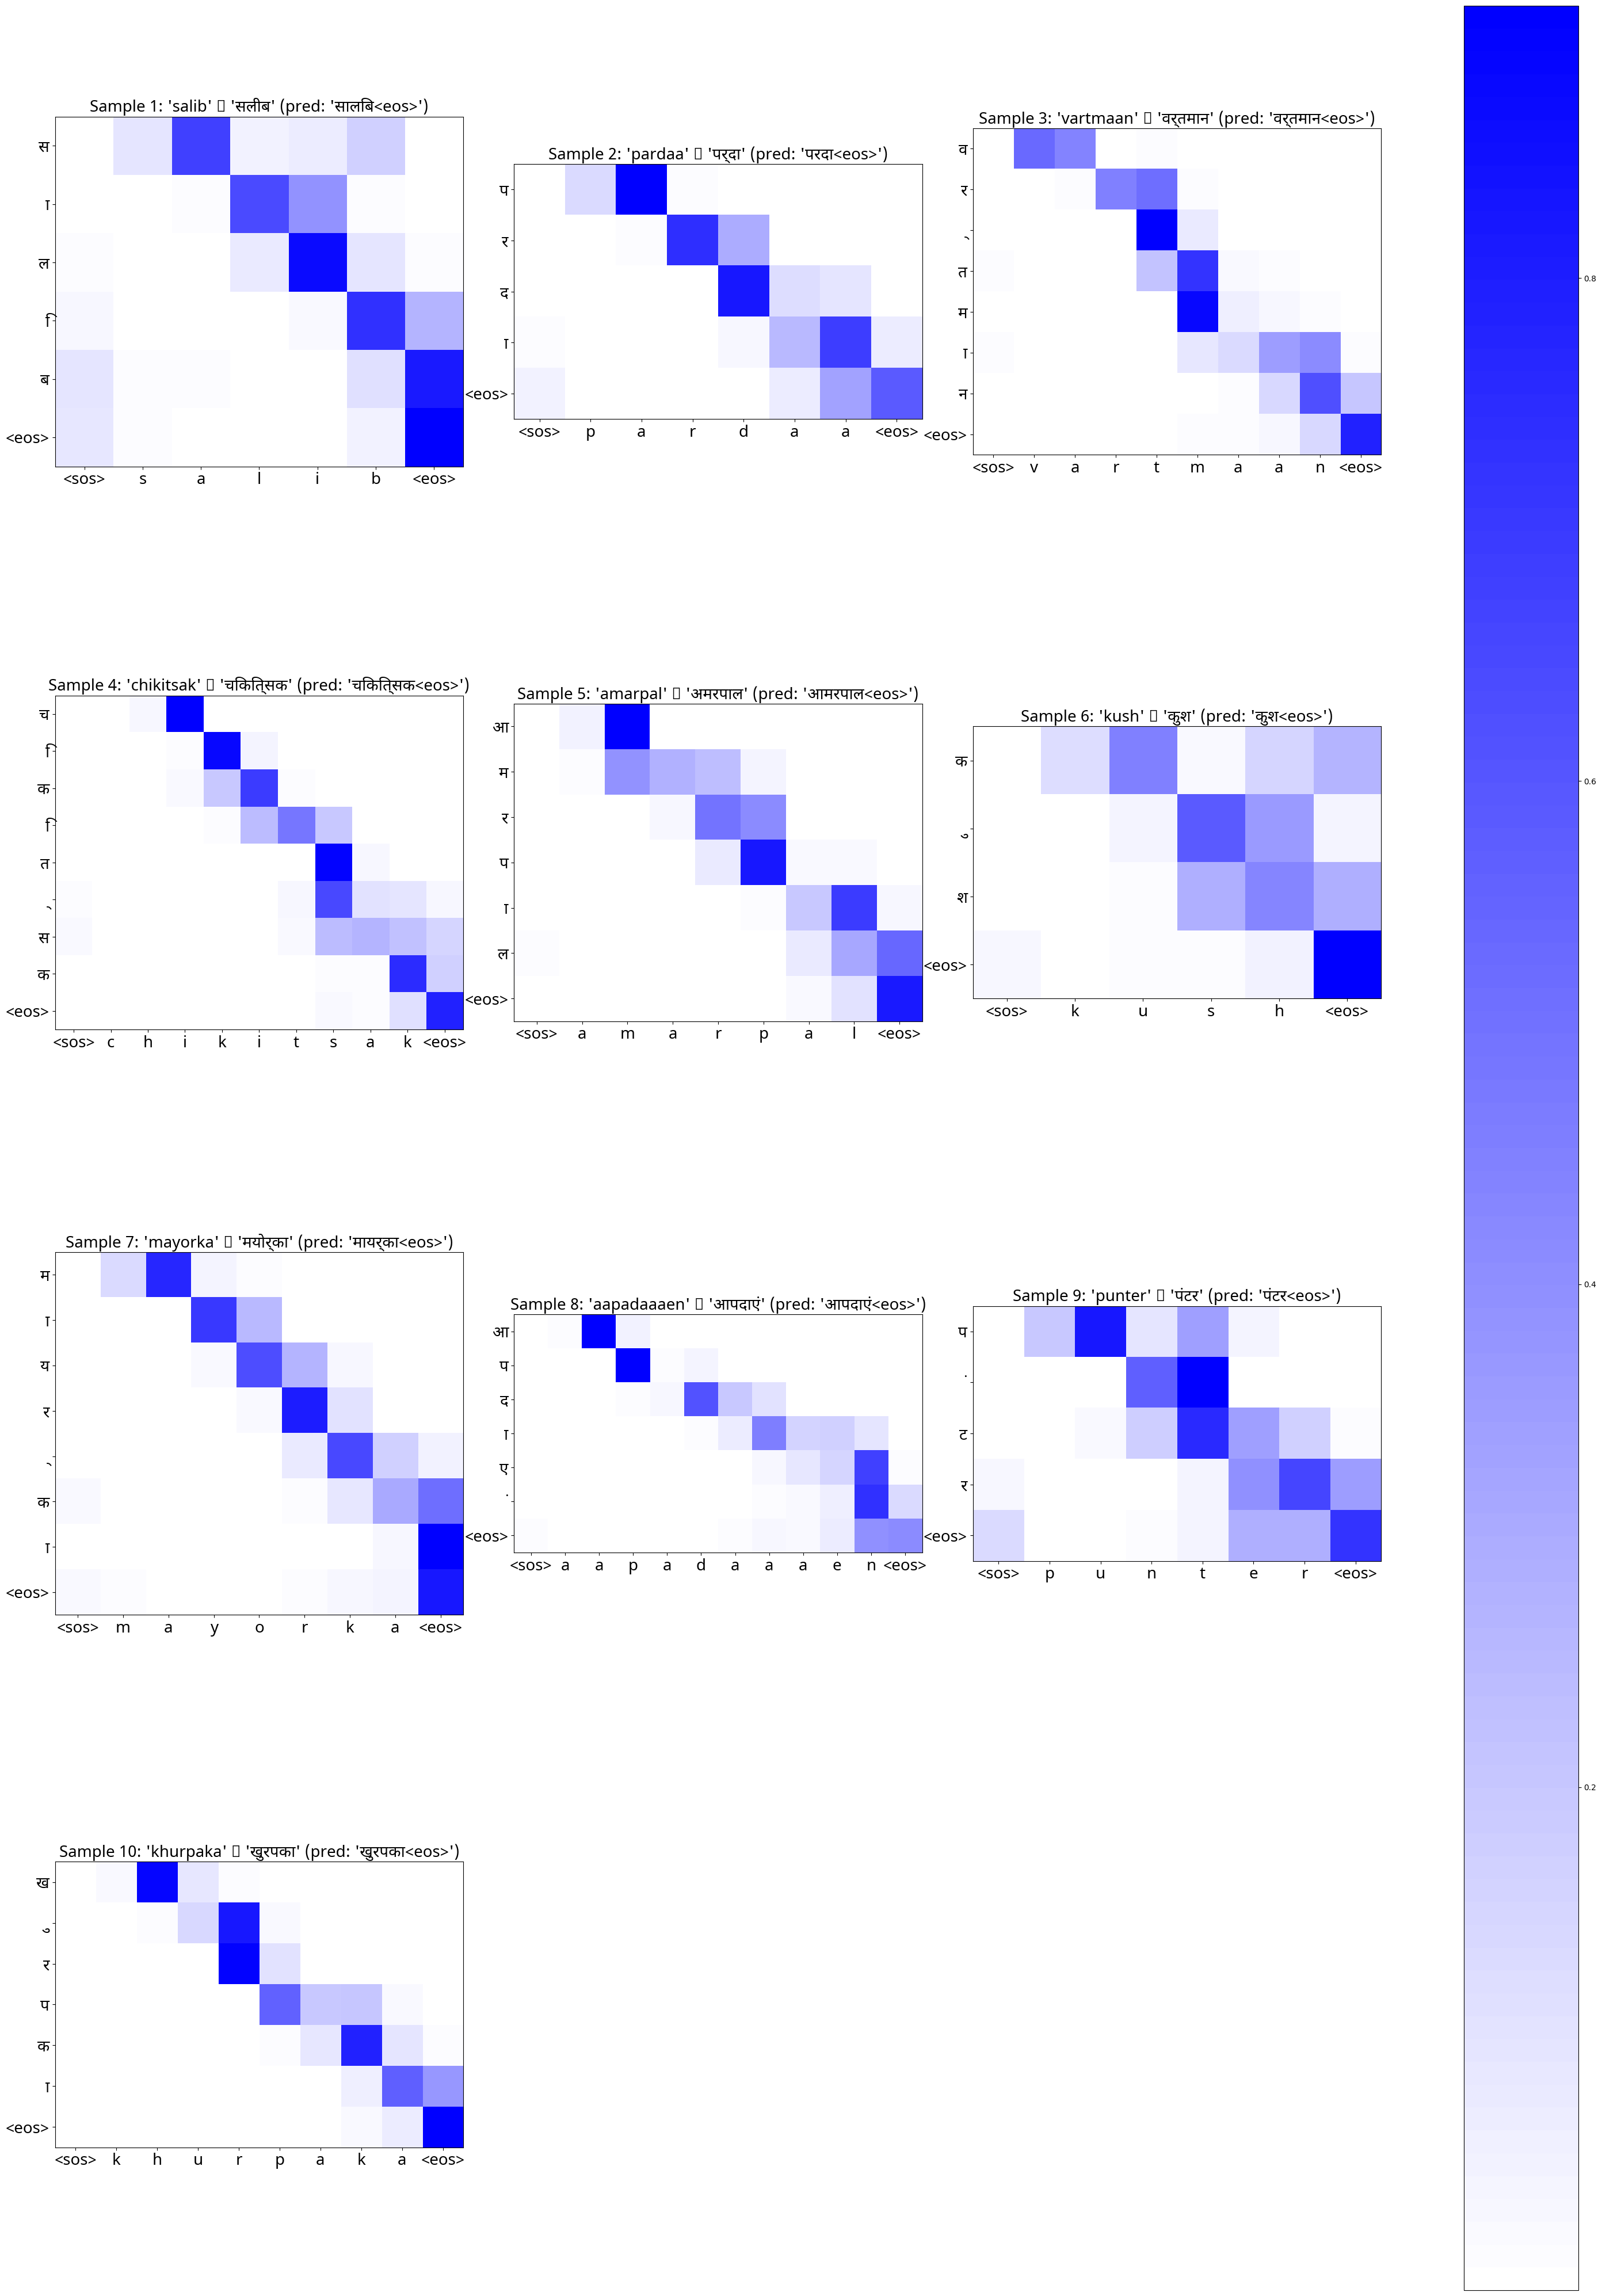

In [46]:
plot_attention_heatmap(model, test_loader, src_vocab, tgt_vocab, device, num_samples=10)